In [3]:
from csv2list import outputcsv
#from csv2list import gen_once
from csv2list import gen4submit
import time
import pickle
import numpy
import torch
import torch.utils.data
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
torch.cuda.empty_cache()
print(time.strftime("%H:%M:%S"), 'start', sep=' ')
with open('./all_data.p', 'rb') as f1:
    d = pickle.load(f1)
    f1.close()
with open('./all_label_1.p', 'rb') as f2:
    l = pickle.load(f2)
    f2.close()
print(time.strftime("%H:%M:%S"), 'read train  Over', sep=' ')
trainset = DataSet(d, l)
d, l = 0, 0
torch.cuda.empty_cache()
print(time.strftime("%H:%M:%S"), 'build train set  Over', sep=' ')
with open('./all_test_data.p', 'rb') as f1:
    d = pickle.load(f1)
    f1.close()
with open('./all_test_label_1.p', 'rb') as f2:
    l = pickle.load(f2)
    f2.close()
testset = DataSet(d, l)
d, l = 0, 0
print(time.strftime("%H:%M:%S"), 'build validate set  Over', sep=' ')
#trainset = testset

18:37:59 start
18:41:10 read train  Over
18:44:00 build train set  Over
18:44:14 build validate set  Over


In [12]:
def train_all(hs, hl, epmax, logfilename, train_loader, test_loader):
    '''
    with open('./train_data_' + str(fd1) + '_' + str(fd2) + '.p', 'rb') as f:
        data_list = pickle.load(f)
    with open('./train_label_' + str(fd1) + '_' + str(fd2) + '.p', 'rb') as f:
        label_list = pickle.load(f)
    dataset = DataSet(data_list, label_list)
    
    train_loader = torch.utils.data.DataLoader(
        dataset=trainset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        dataset=testset, batch_size=batch_size, shuffle=True)
    '''
    NN = FundLSTM(input_size=input_size, hidden_size=hs, hidden_layers=hl, output_size=output_size).cuda()
    lossfunc = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(NN.parameters(), lr=lr, weight_decay=weight_decay)


    tr_ls = []
    te_ls = []
    T = 0.0
    for epoch in range(epmax):  
        # print('current epoch = %d' % (epoch+1))
        train_loss = 0.0
        test_total_loss = 0.0
        train_batch_cnt, validation_batch_cnt = 0, 0
        # T = time.time()
        for key, value in train_loader:
            train_batch_cnt += 1
            key = torch.autograd.Variable(key)
            value = torch.autograd.Variable(value)
            optimizer.zero_grad()
            outputs = NN(key).squeeze()
            loss = lossfunc(outputs, value)
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()
            train_loss += loss
            # if i % 100 == 0:
                # print('current loss = %.5f' % loss.item())
        with torch.no_grad():
            for key, value in test_loader:
                validation_batch_cnt += 1
                outputs = NN(key).squeeze()[-1]
                loss = lossfunc(outputs, value)
                test_total_loss += loss
        tr_ls.append(train_loss.data / train_batch_cnt)
        te_ls.append(test_total_loss.data / validation_batch_cnt)
        # print(time.time()-T)
        #if epoch > 0:
    epoches = range(1, epmax+1)
    plt.plot(epoches, tr_ls, label='Trainning Loss', color='blue')
    plt.plot(epoches, te_ls, label='Validation Loss', color='red')
    plt.title('Loss')
    plt.xlabel('epoches')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(str(hs)+'_'+str(hl)+'.png')
    plt.close('all')
    #plt.show()
    with open(logfilename, 'a+') as f:
        tr_ls = numpy.array(tr_ls)
        te_ls = numpy.array(te_ls)
        f.write(str(hs)+','+str(hl)+','+str(numpy.min(te_ls))+','+str(int((numpy.where(te_ls==numpy.min(te_ls)))[0])+1)+','+ 
                str(numpy.min(tr_ls))+','+str(int((numpy.where(tr_ls==numpy.min(tr_ls)))[0])+1))
        f.write('\n')
        f.close()
    torch.save(NN.state_dict(), './weight_'+str(hs)+'_'+str(hl)+'.p')
    #return NN

In [ ]:
for i in range(len(h)):
    e = h[i]
    print('hidden_size=',e[0], ' ', 'hidden_layers=', e[1], ' start', sep=' ')
    T = time.time()
    train_all(e[0], e[1], 46, 'log.csv', train_loader, test_loader)
    print('hidden_size=',e[0], ' ', 'hidden_layers=', e[1], ' done', sep=' ')
    print(time.time() - T)

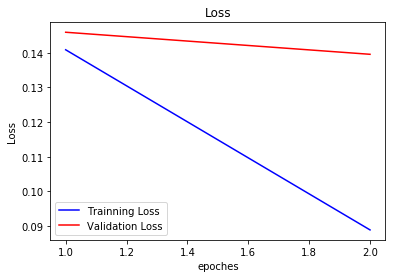

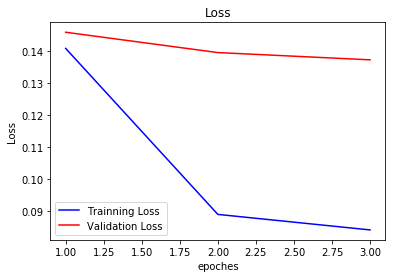

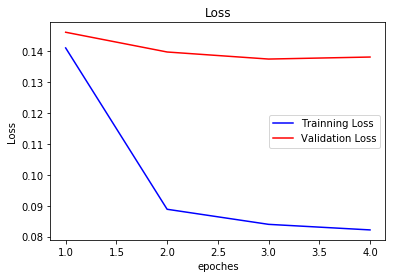

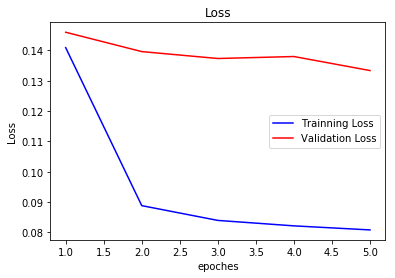

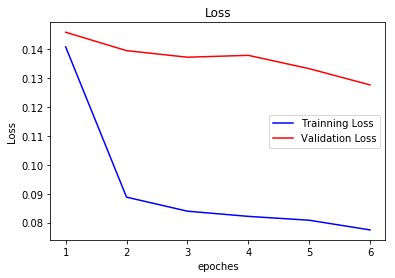

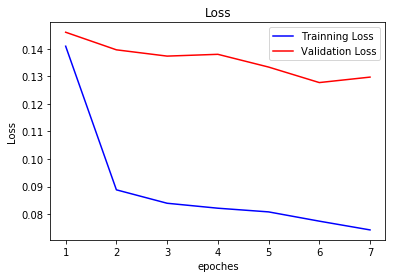

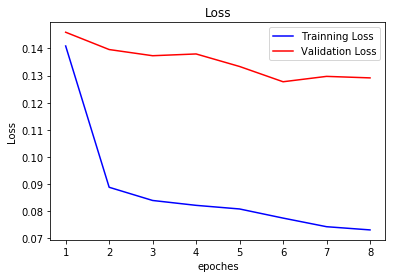

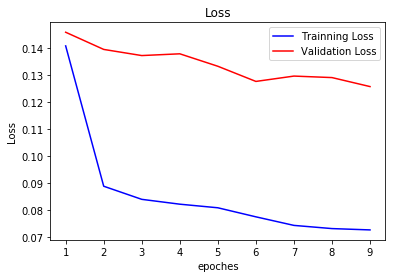

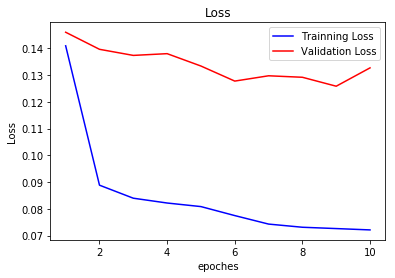

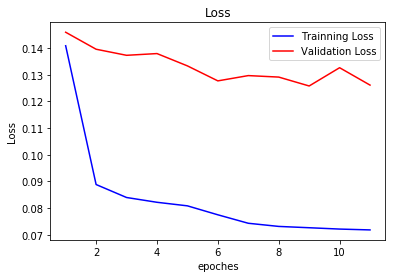

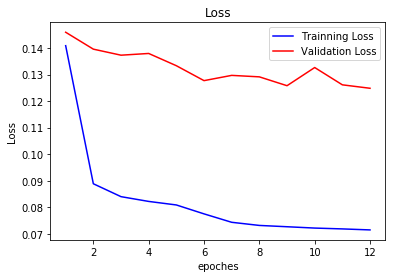

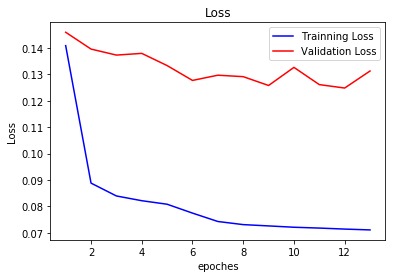

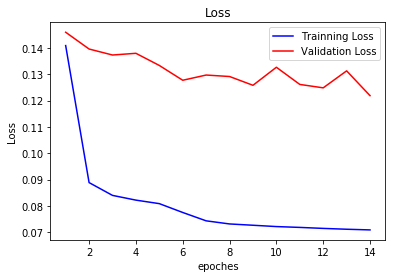

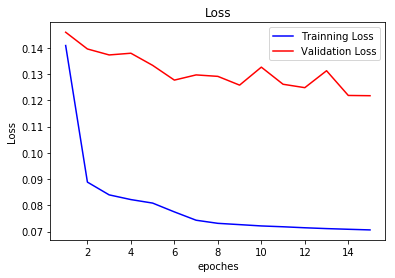

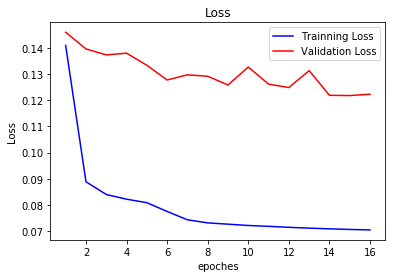

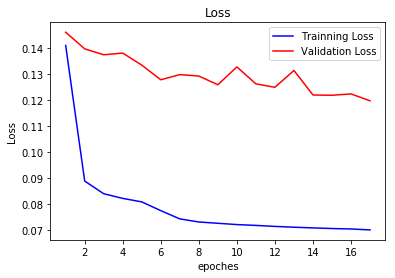

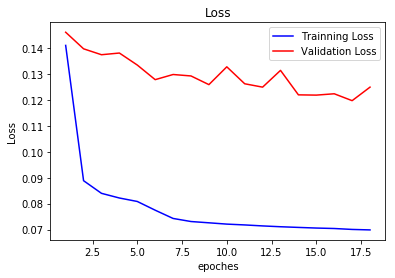

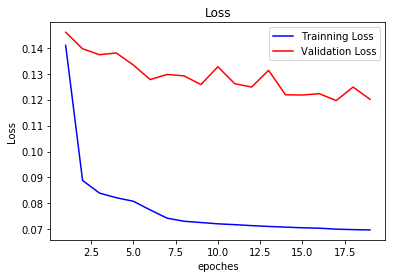

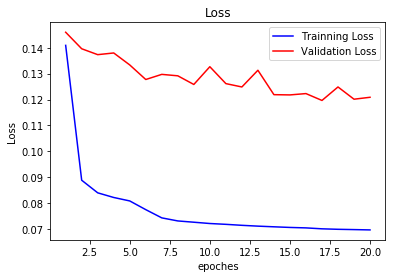

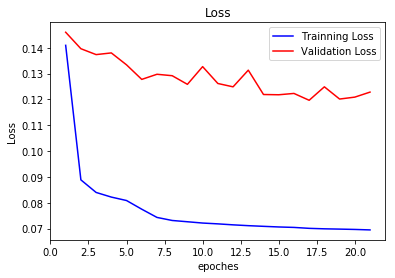

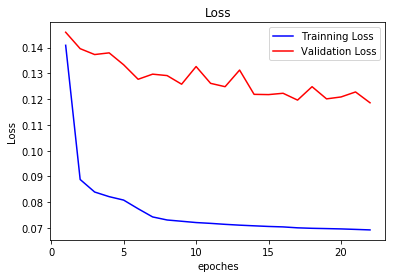

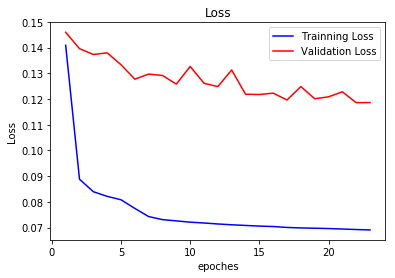

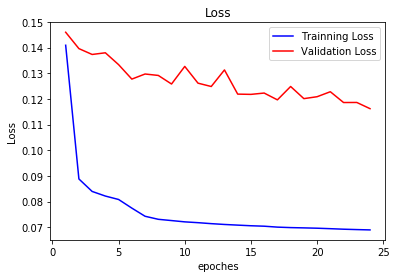

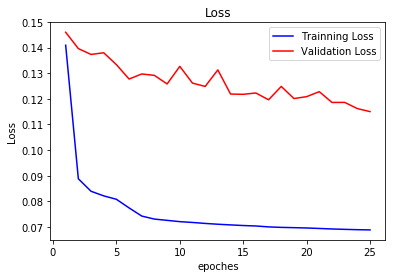

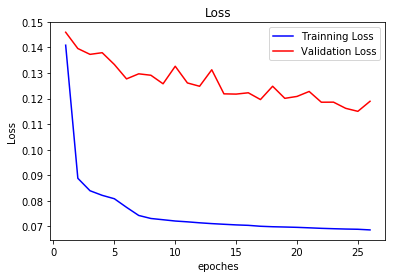

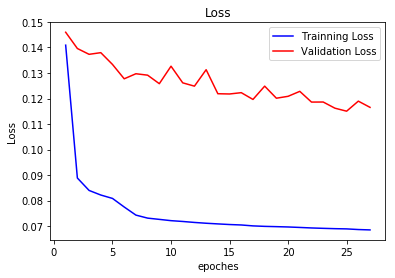

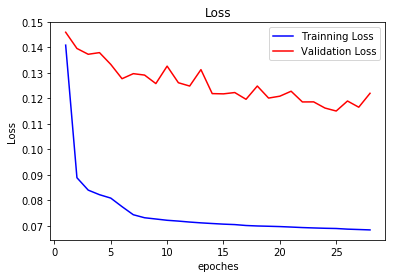

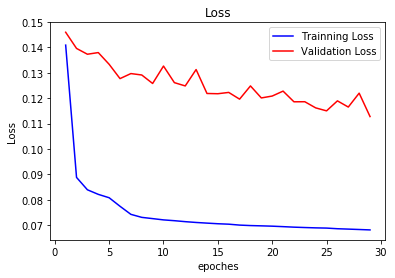

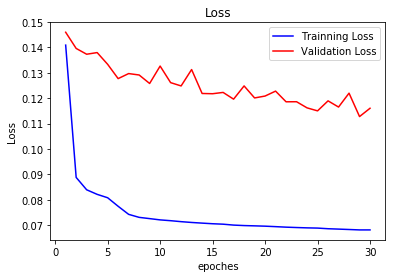

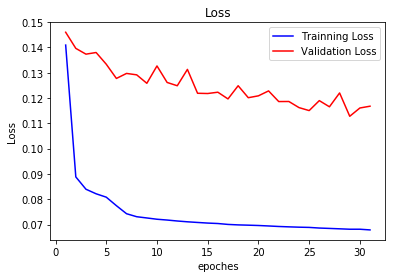

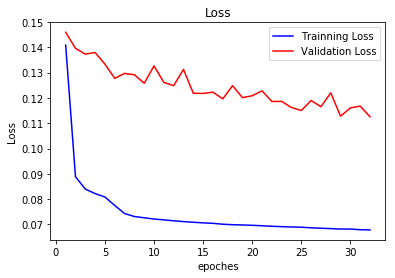

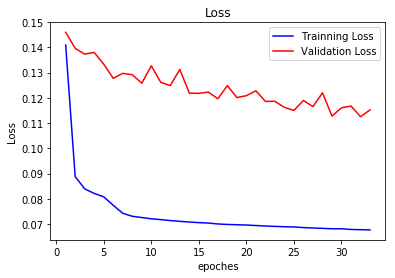

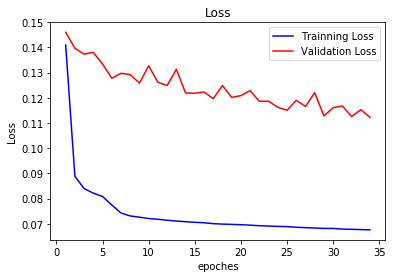

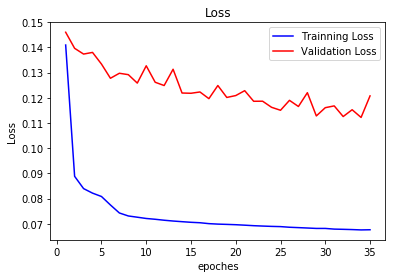

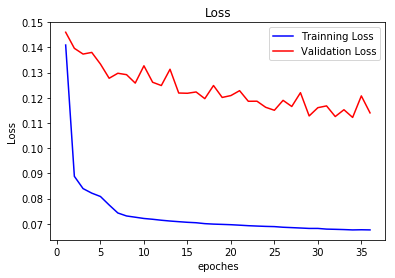

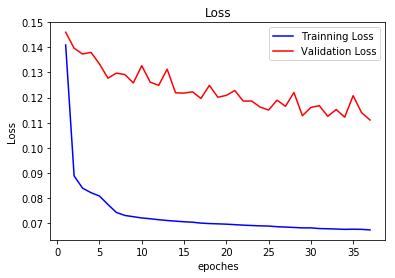

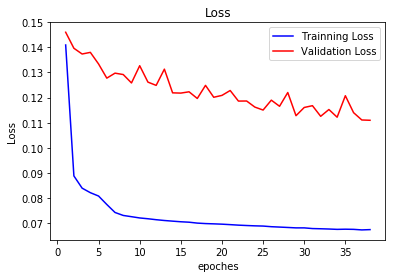

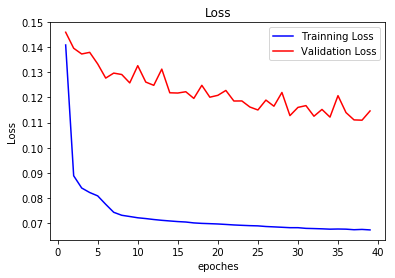

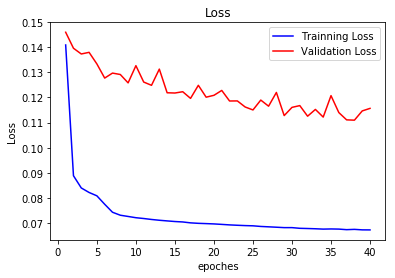

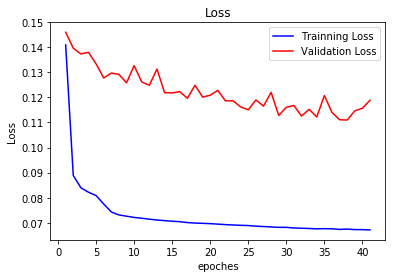

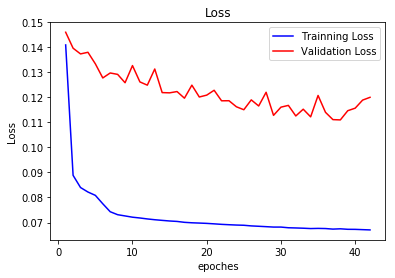

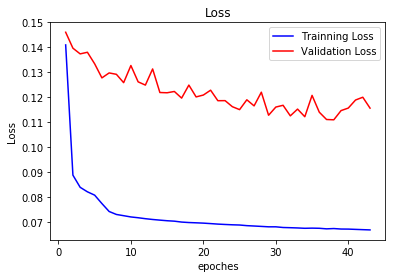

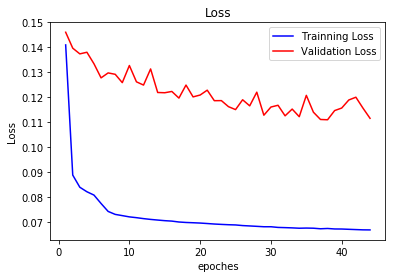

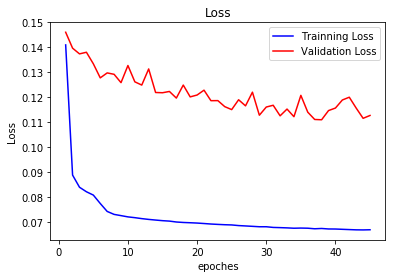

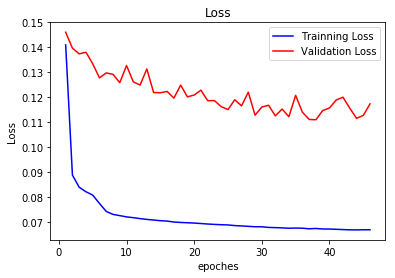

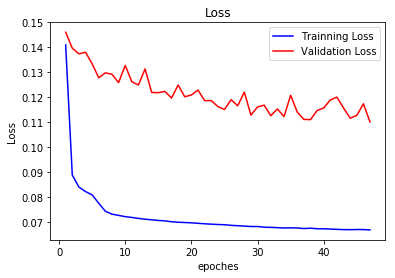

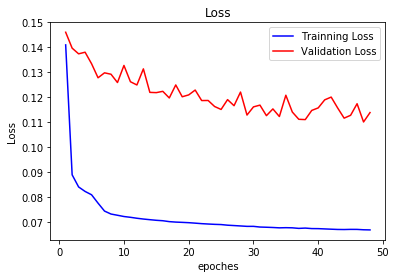

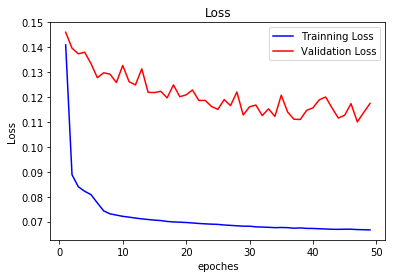

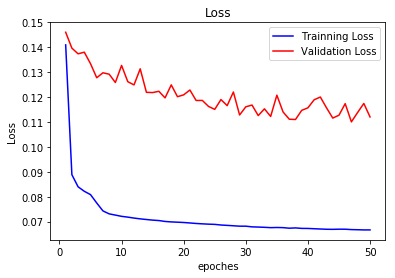

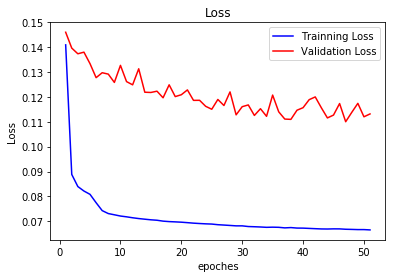

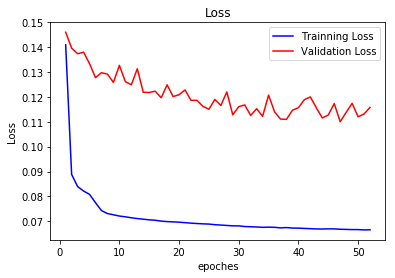

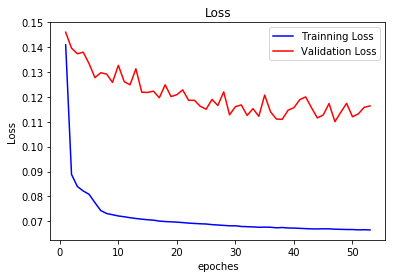

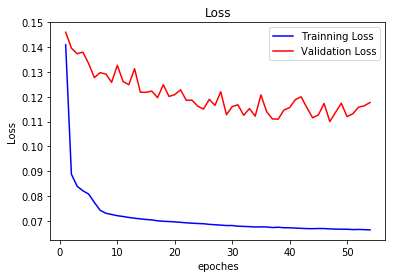

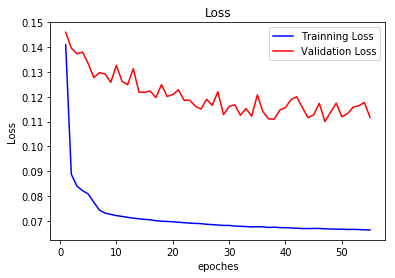

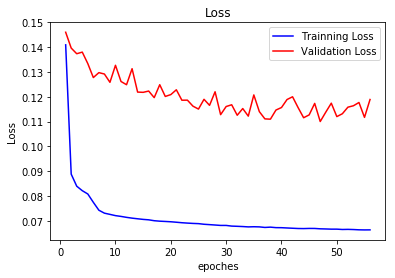

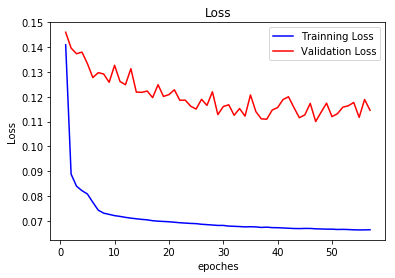

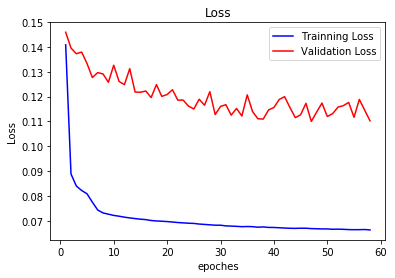

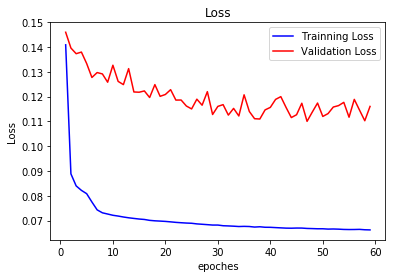

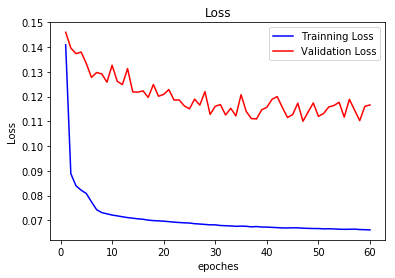

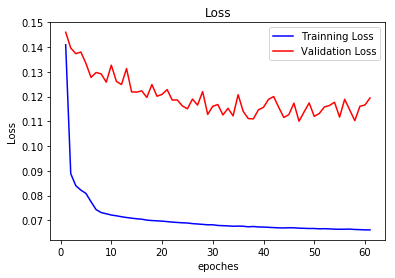

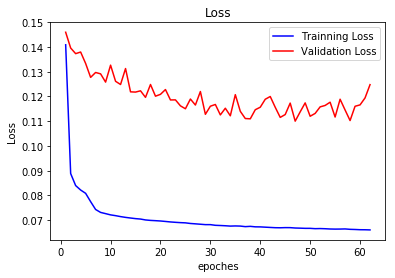

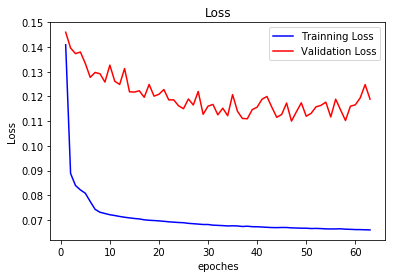

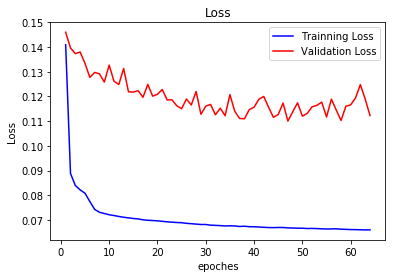

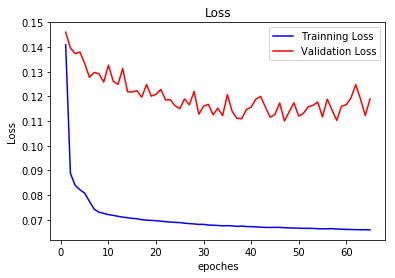

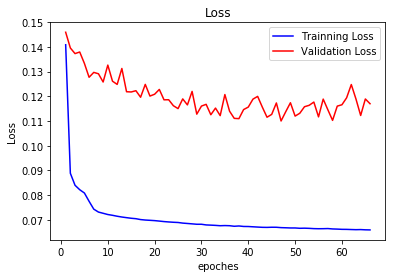

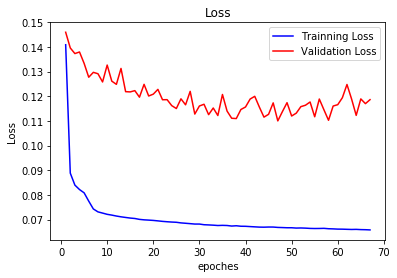

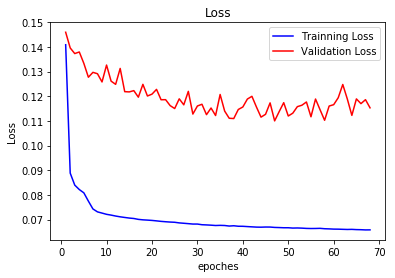

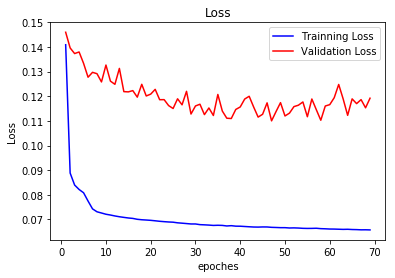

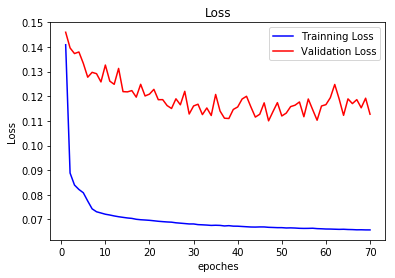

16,2,0.11001807,47,0.06576136,70


In [17]:
train(16, 2, 70, 'log.csv', train_loader, test_loader)

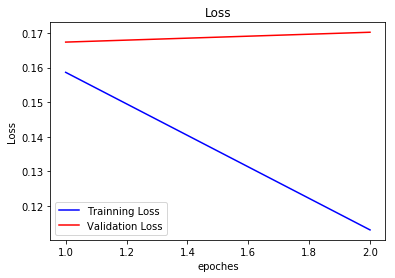

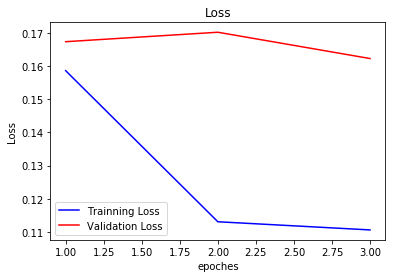

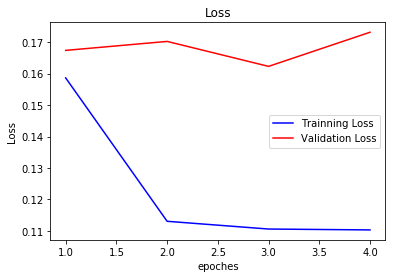

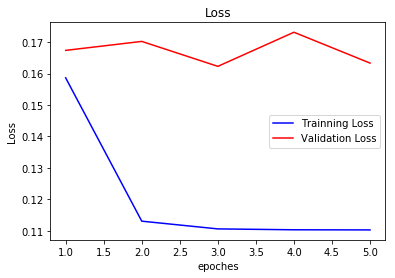

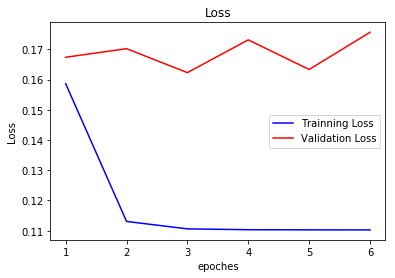

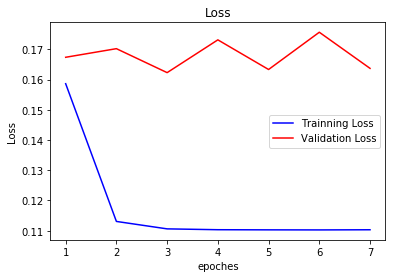

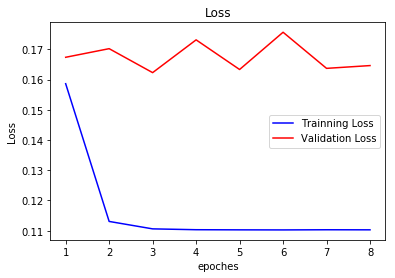

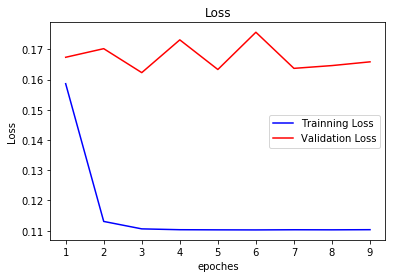

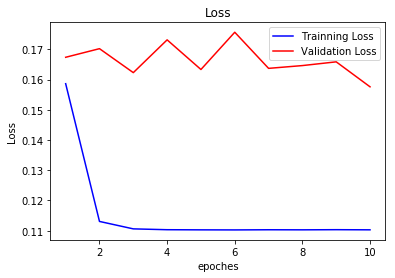

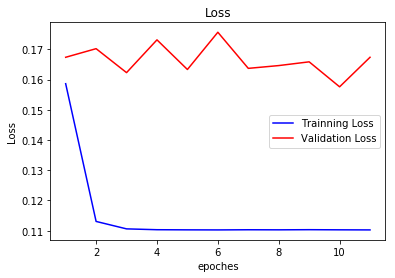

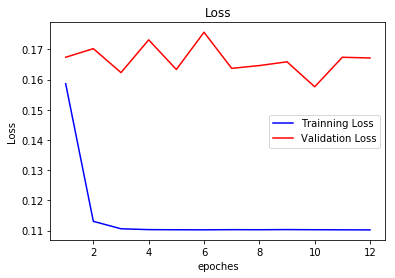

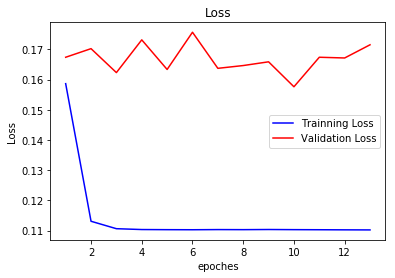

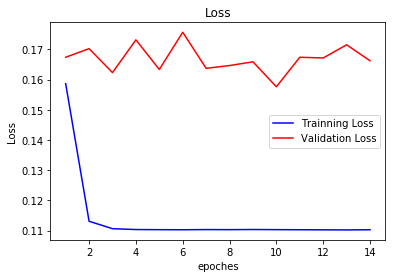

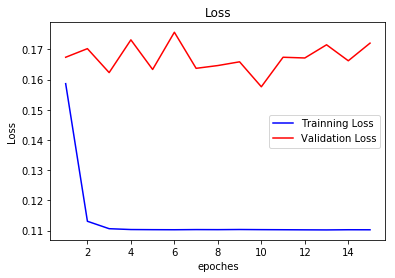

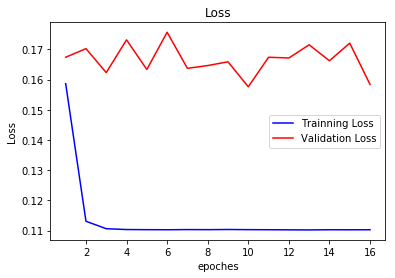

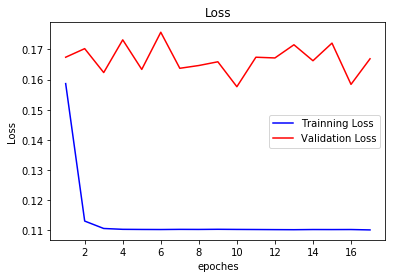

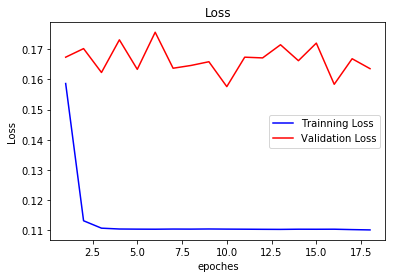

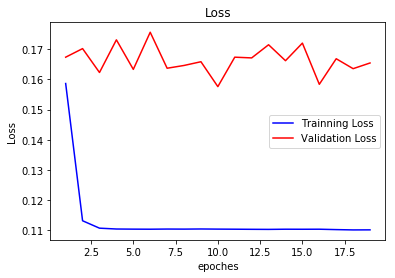

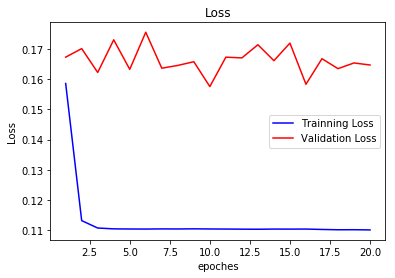

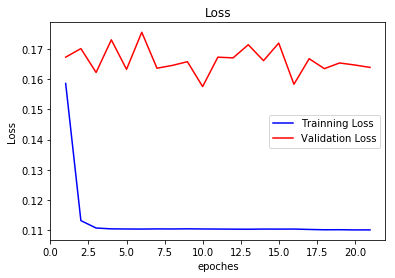

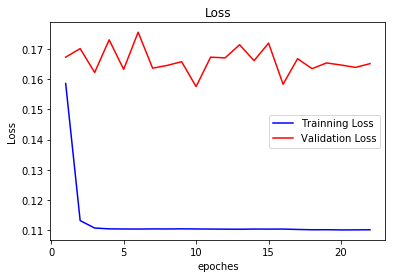

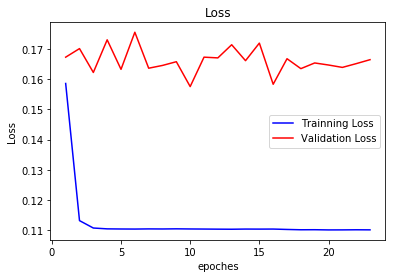

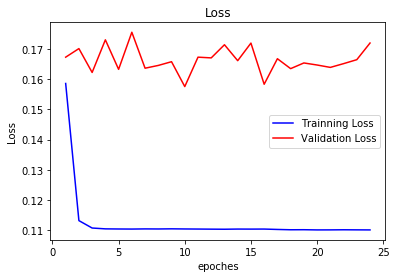

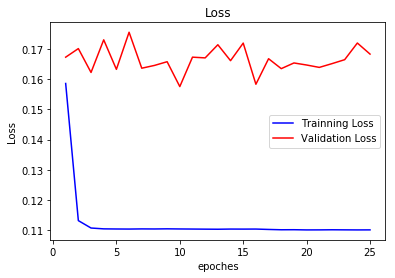

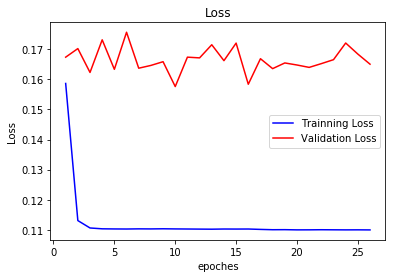

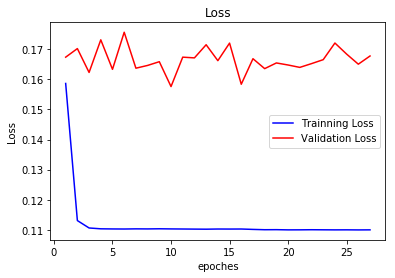

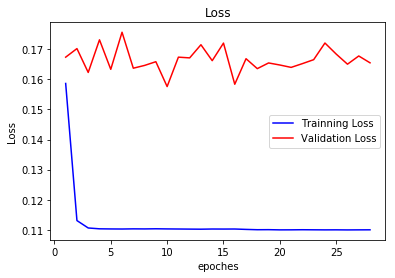

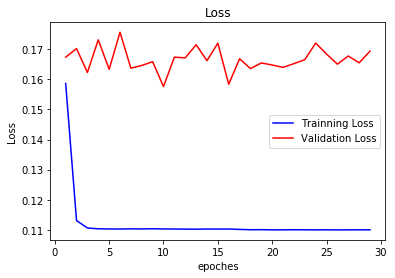

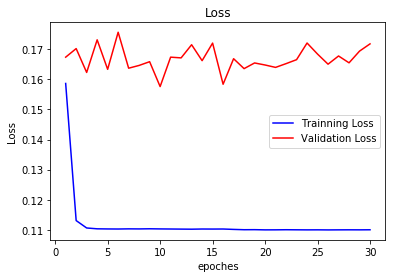

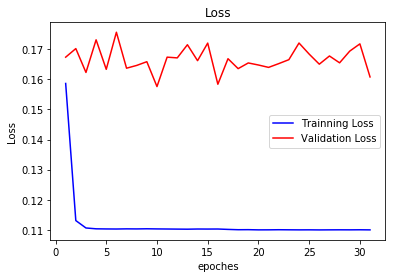

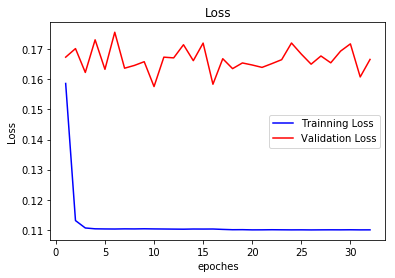

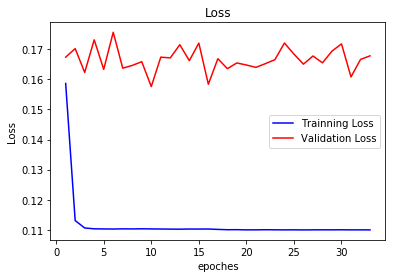

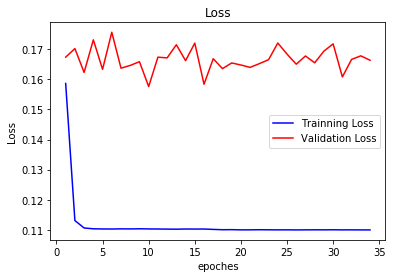

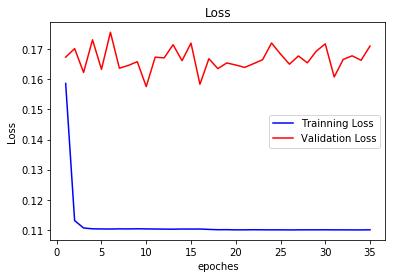

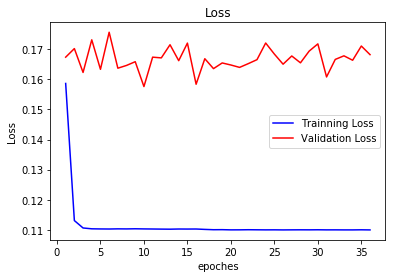

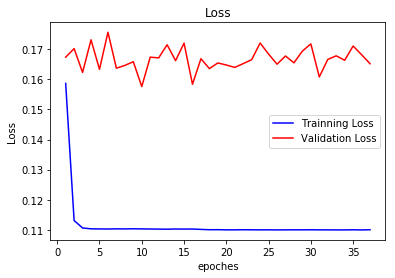

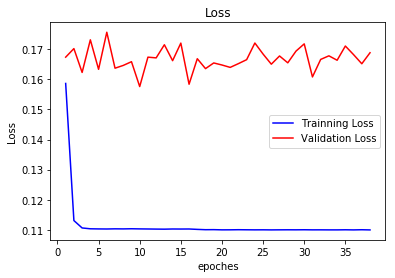

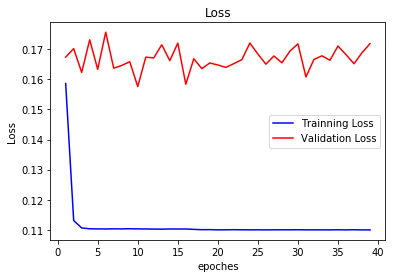

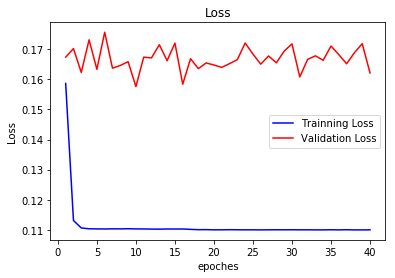

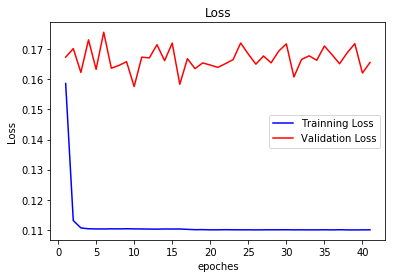

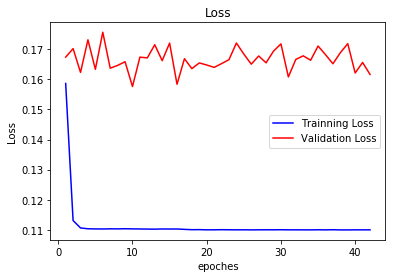

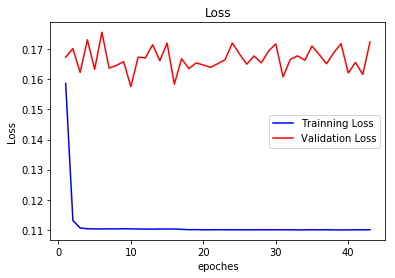

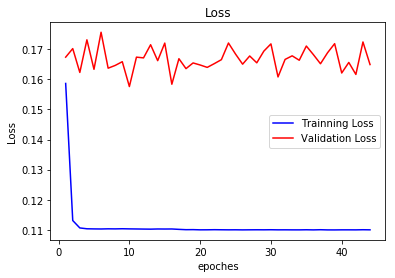

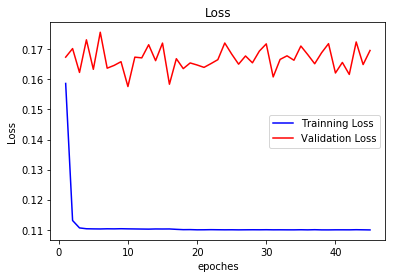

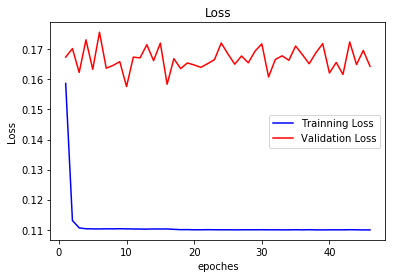

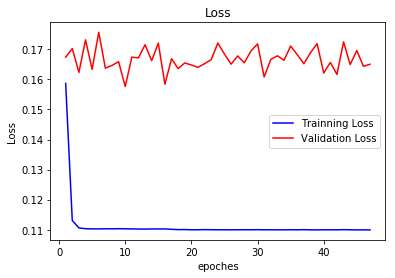

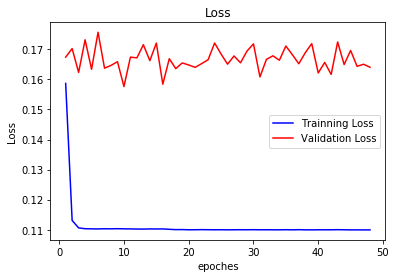

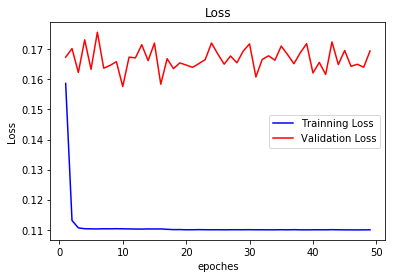

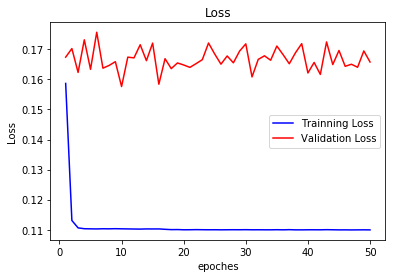

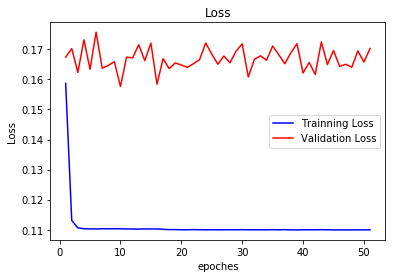

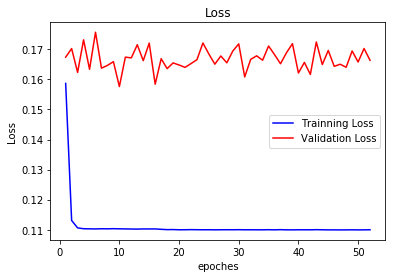

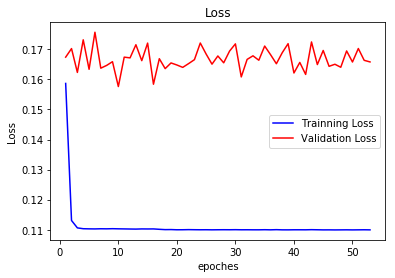

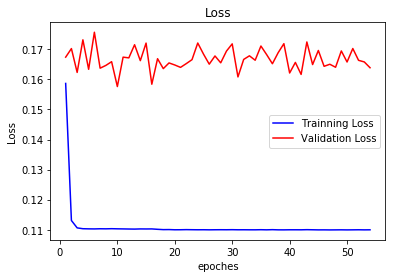

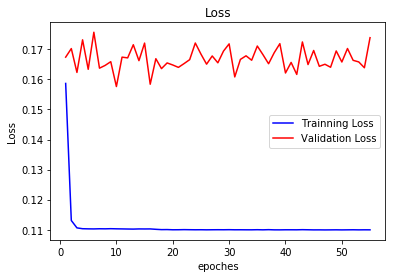

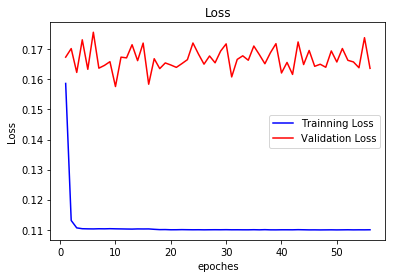

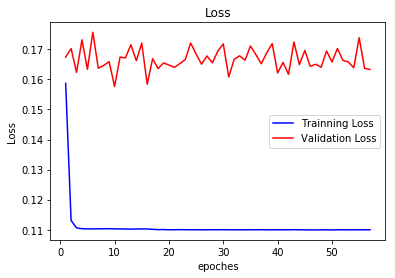

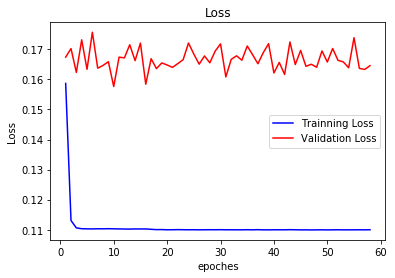

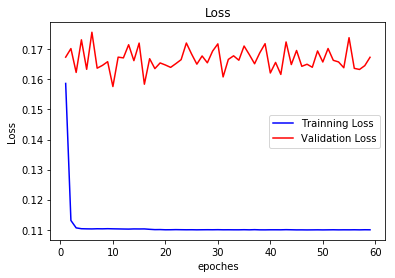

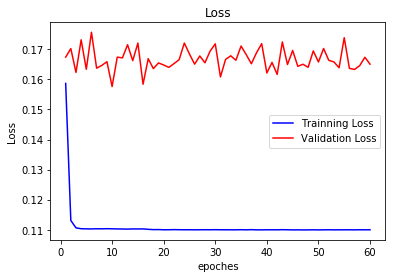

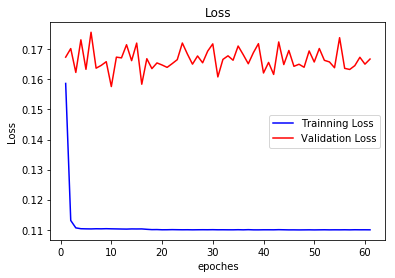

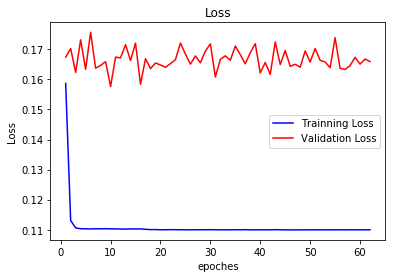

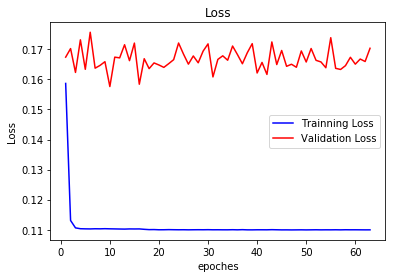

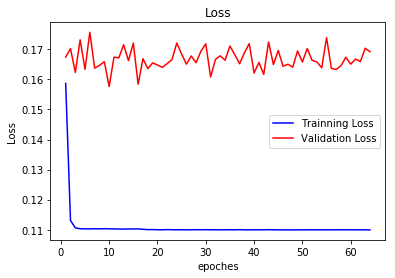

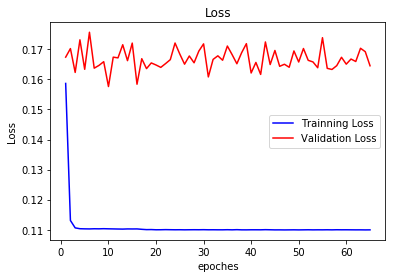

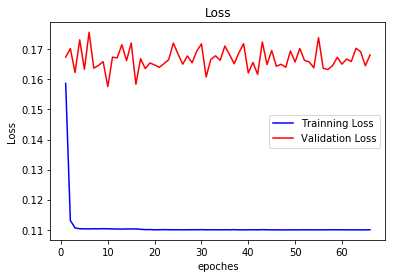

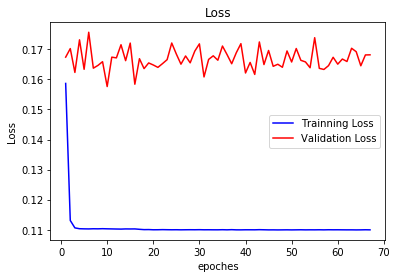

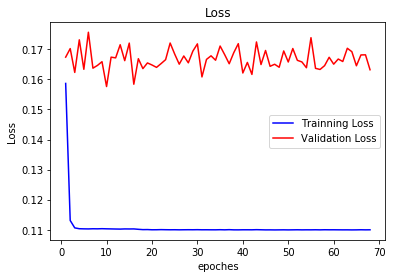

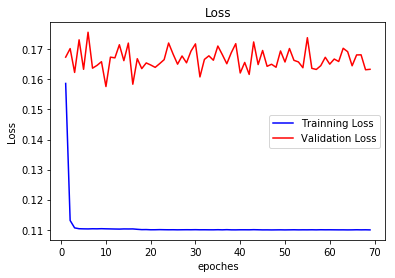

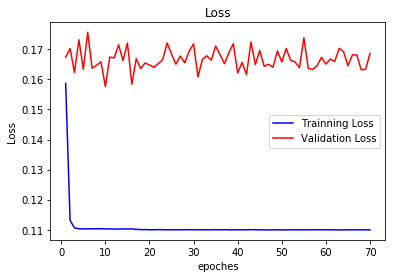

12,8,0.15761684,10,0.10992452,47


In [19]:
train(12, 8, 70, 'log.csv', train_loader, test_loader)

In [32]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, keys, values):
        self.keys = torch.Tensor(keys).cuda()
        self.values = torch.Tensor(values).cuda()

    def __getitem__(self, index):
        indata = self.keys[index]
        outdata = self.values[index]
        return indata, outdata

    def __len__(self):
        return len(self.values)


class FundLSTM(torch.nn.Module):
    def __init__(self, input_size, output_size,
                 hidden_size, hidden_layers):
        super(FundLSTM, self).__init__()
        self.rnn = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=hidden_layers,
            dropout=dropout,
            batch_first=True
        )
        self.output = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x.shape = (batch, time_step, input_size)
        # out.shape = (batch, time_step, output_size)
        # h_n (branch) (n_layers, batch, hidden_size)
        # h_c (main) (n_layers, batch, hidden_size)
        out, (h_n, h_c) = self.rnn(x, None)
        out = self.output(out[:, -1:, :])
        return out


In [33]:
def train(hs, hl, epmax, logfilename, train_loader, test_loader):
    '''
    with open('./train_data_' + str(fd1) + '_' + str(fd2) + '.p', 'rb') as f:
        data_list = pickle.load(f)
    with open('./train_label_' + str(fd1) + '_' + str(fd2) + '.p', 'rb') as f:
        label_list = pickle.load(f)
    dataset = DataSet(data_list, label_list)
    
    train_loader = torch.utils.data.DataLoader(
        dataset=trainset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        dataset=testset, batch_size=batch_size, shuffle=True)
    '''
    NN = FundLSTM(input_size=input_size, hidden_size=hs, hidden_layers=hl, output_size=output_size).cuda()
    lossfunc = FundLoss()
    optimizer = torch.optim.Adam(NN.parameters(), lr=lr, weight_decay=weight_decay)


    tr_ls = []
    te_ls = []
    T = 0.0
    for epoch in range(epmax):  
        # print('current epoch = %d' % (epoch+1))
        train_loss = 0.0
        test_total_loss = 0.0
        train_batch_cnt, validation_batch_cnt = 0, 0
        # T = time.time()
        for key, value in train_loader:
            train_batch_cnt += 1
            key = torch.autograd.Variable(key)
            value = torch.autograd.Variable(value)
            optimizer.zero_grad()
            outputs = NN(key).squeeze()
            loss = lossfunc(outputs, value)
            loss.backward()
            optimizer.step()
            train_loss += loss
            # if i % 100 == 0:
                # print('current loss = %.5f' % loss.item())
        with torch.no_grad():
            for key, value in test_loader:
                validation_batch_cnt += 1
                outputs = NN(key).squeeze()
                loss = lossfunc(outputs, value)
                test_total_loss += loss
        tr_ls.append(train_loss.data / train_batch_cnt)
        te_ls.append(test_total_loss.data / validation_batch_cnt)
        # print(time.time()-T)
        if int((numpy.where(te_ls == numpy.min(te_ls)))[0]) + 1 == epoch+1 and numpy.min(te_ls)<0.218:
            torch.save(NN.state_dict(), './weight_' + str(hs) + '_' + str(hl) + '_' + str(int(epoch+1)) + '_'+ str(numpy.min(te_ls))+'.p')
        print(str(numpy.min(te_ls))+','+str(int((numpy.where(te_ls==numpy.min(te_ls)))[0])+1)+','+str(te_ls[-1]))
        
        if epoch > 0:     
            if (int((numpy.where(te_ls == numpy.min(te_ls)))[0]) + 1 == epoch+1 and epoch>6) or epoch >=14:
                epoches = range(1, epoch+2)
                plt.plot(epoches, tr_ls, label='Trainning Loss', color='blue')
                plt.plot(epoches, te_ls, label='Validation Loss', color='red')
                plt.xlabel('epoches')
                plt.ylabel('Loss')
                plt.legend()
                #plt.savefig(str(hs)+'_'+str(hl)+'.png')
                #plt.close('all')
                plt.show()
        
    '''
    with open(logfilename, 'a+') as f:
        tr_ls = numpy.array(tr_ls)
        te_ls = numpy.array(te_ls)
        f.write(str(hs)+','+str(hl)+','+str(numpy.min(te_ls))+','+str(int((numpy.where(te_ls==numpy.min(te_ls)))[0])+1)+','+ 
                str(numpy.min(tr_ls))+','+str(int((numpy.where(tr_ls==numpy.min(tr_ls)))[0])+1))
        f.write('\n')
        f.close()
    '''
    epoches = range(1, epmax+1)
    plt.plot(epoches, tr_ls, label='Trainning Loss', color='blue')
    plt.plot(epoches, te_ls, label='Validation Loss', color='red')
    plt.xlabel('epoches')
    plt.ylabel('Loss')
    plt.legend()
    #plt.savefig(str(hs)+'_'+str(hl)+'.png')
    #plt.close('all')
    plt.show()
    print(str(hs)+','+str(hl)+','+str(numpy.min(te_ls))+','+str(int((numpy.where(te_ls==numpy.min(te_ls)))[0])+1)+','+ 
                str(numpy.min(tr_ls))+','+str(int((numpy.where(tr_ls==numpy.min(tr_ls)))[0])+1))
    # torch.save(NN.state_dict(), './single_weight_'+str(hs)+'_'+str(hl)+'.p')
    #return NN

In [34]:
time_step = 61
batch_size = 512
lr = 1e-3
weight_decay = 1e-5
input_size = 38
output_size = 1

epochmax = 46
dropout = 0.2

'''
hidden_layers = [2,4,8,12,16,20,24]
hidden_size = [16,20,24,28]
h = [(20,8), (20,12), (24,2), (24,4), (24,8), (24,12), (24,16), 
     (28,2), (28,4), (28,8), (28,12), (28,16), (32, 2), (32, 4), (32, 8), (32, 12), (32, 16)]
'''
train_loader = torch.utils.data.DataLoader(
        dataset=trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        dataset=testset, batch_size=batch_size, shuffle=True)

class FundLoss(torch.nn.Module):
    def __init__(self):
        super(FundLoss, self).__init__()

    def forward(self, pred, truth):
        # MAE = (pred-truth).abs().mean()
        # TMAPE = ((pred-truth).abs() / (torch.full_like(truth, 1.5)-truth).abs()).mean
        return  torch.mean(torch.abs(pred-truth))+torch.mean(torch.abs(pred-truth) / torch.abs(torch.full_like(truth, 1.5).cuda()-truth))

21:27:16
0.27881724,1,tensor(0.2788, device='cuda:0')
0.27458027,2,tensor(0.2746, device='cuda:0')
0.27458027,2,tensor(0.2758, device='cuda:0')
0.27074212,4,tensor(0.2707, device='cuda:0')
0.25058642,5,tensor(0.2506, device='cuda:0')
0.25058642,5,tensor(0.3073, device='cuda:0')
0.25058642,5,tensor(0.2875, device='cuda:0')
0.2308883,8,tensor(0.2309, device='cuda:0')


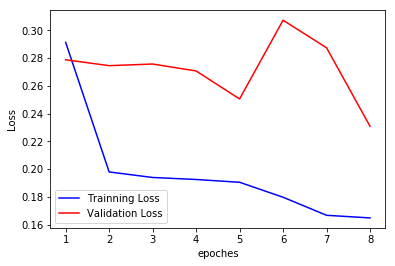

0.2308883,8,tensor(0.2572, device='cuda:0')
0.2308883,8,tensor(0.2358, device='cuda:0')
0.2308883,8,tensor(0.2506, device='cuda:0')
0.2308883,8,tensor(0.2610, device='cuda:0')
0.2308883,8,tensor(0.2418, device='cuda:0')
0.2308883,8,tensor(0.2419, device='cuda:0')
0.2308883,8,tensor(0.2371, device='cuda:0')


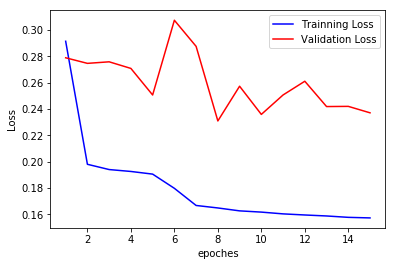

0.2308883,8,tensor(0.2602, device='cuda:0')


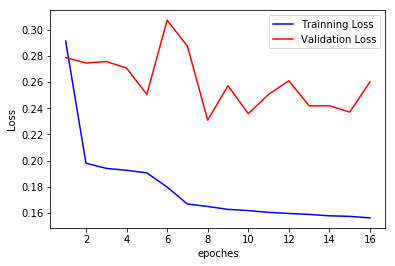

0.2308883,8,tensor(0.2523, device='cuda:0')


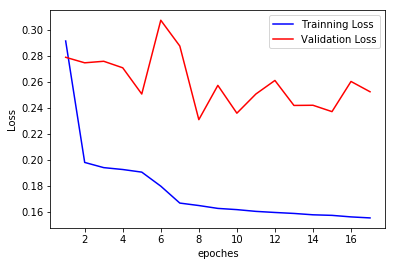

0.2308883,8,tensor(0.2633, device='cuda:0')


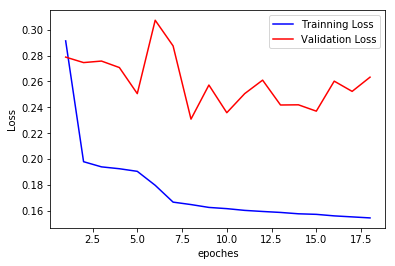

0.2308883,8,tensor(0.3061, device='cuda:0')


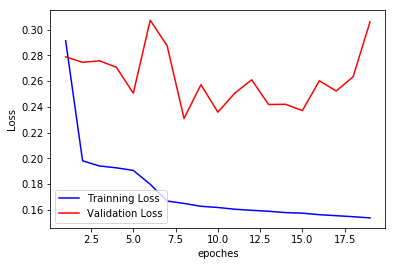

0.2308883,8,tensor(0.2718, device='cuda:0')


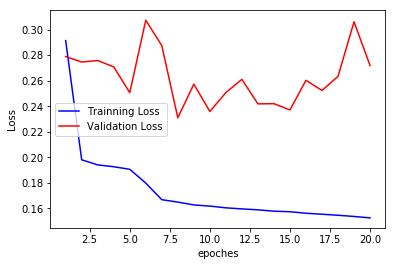

0.2308883,8,tensor(0.2943, device='cuda:0')


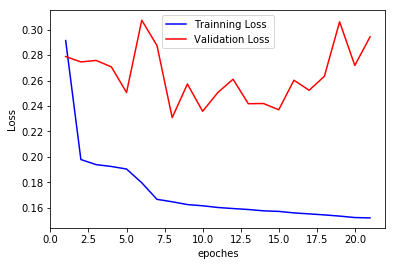

0.2308883,8,tensor(0.2569, device='cuda:0')


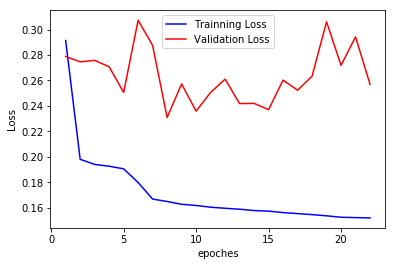

0.2308883,8,tensor(0.2927, device='cuda:0')


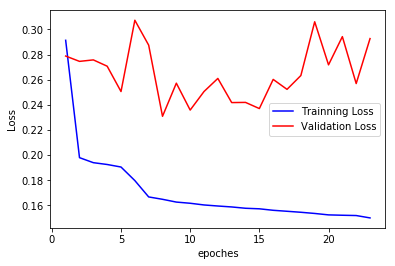

0.2308883,8,tensor(0.2860, device='cuda:0')


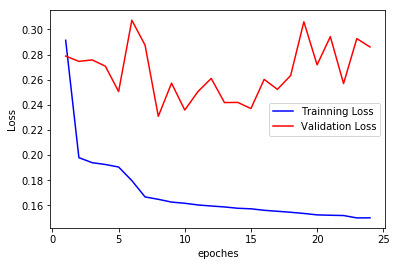

0.2308883,8,tensor(0.2571, device='cuda:0')


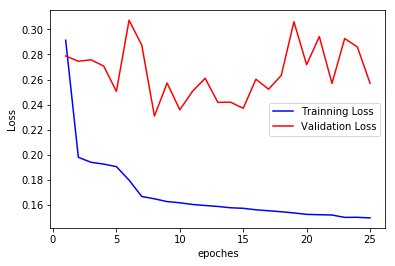

0.2308883,8,tensor(0.2871, device='cuda:0')


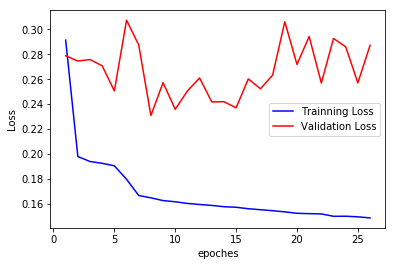

0.2308883,8,tensor(0.3077, device='cuda:0')


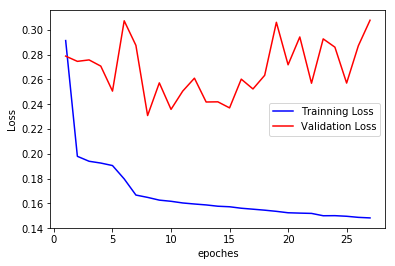

0.2308883,8,tensor(0.2928, device='cuda:0')


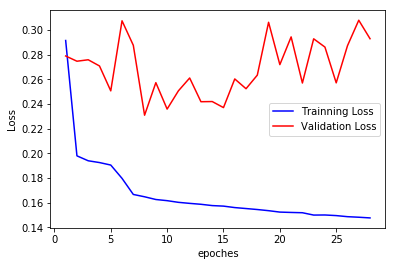

0.2308883,8,tensor(0.2737, device='cuda:0')


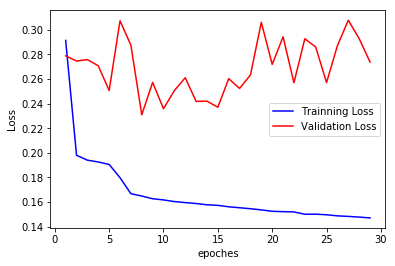

0.2308883,8,tensor(0.2861, device='cuda:0')


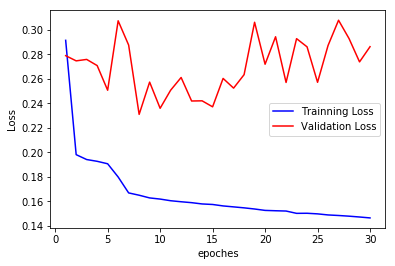

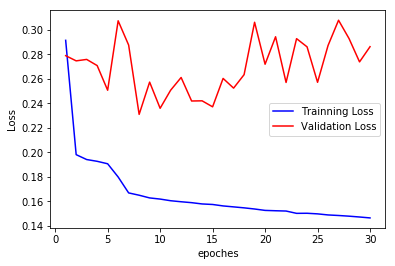

32,2,0.2308883,8,0.14633171,30
21:47:51 1235.3618569374084
21:47:51
0.27180567,1,tensor(0.2718, device='cuda:0')
0.26875606,2,tensor(0.2688, device='cuda:0')
0.26875606,2,tensor(0.2691, device='cuda:0')
0.26875606,2,tensor(0.2725, device='cuda:0')
0.25190318,5,tensor(0.2519, device='cuda:0')
0.25190318,5,tensor(0.3458, device='cuda:0')
0.25190318,5,tensor(0.3502, device='cuda:0')
0.25190318,5,tensor(0.3327, device='cuda:0')
0.25190318,5,tensor(0.3069, device='cuda:0')
0.25190318,5,tensor(0.2848, device='cuda:0')
0.24871844,11,tensor(0.2487, device='cuda:0')


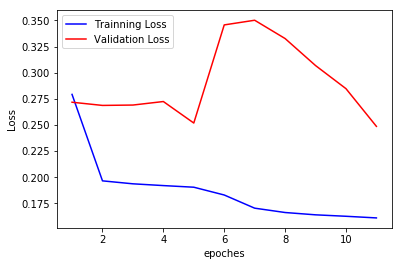

0.24100563,12,tensor(0.2410, device='cuda:0')


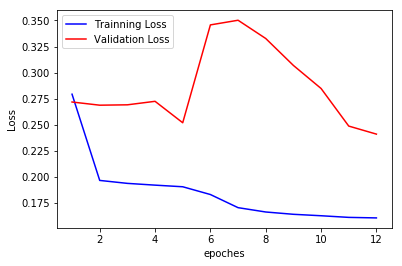

0.24100563,12,tensor(0.2524, device='cuda:0')
0.24100563,12,tensor(0.2928, device='cuda:0')
0.23719755,15,tensor(0.2372, device='cuda:0')


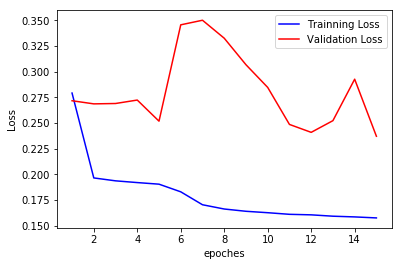

0.23719755,15,tensor(0.2432, device='cuda:0')


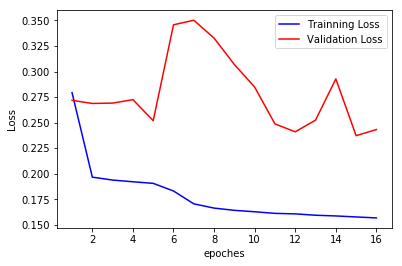

0.23719755,15,tensor(0.2828, device='cuda:0')


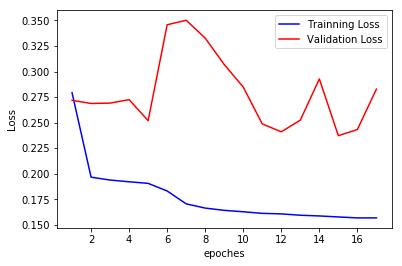

0.23719755,15,tensor(0.2851, device='cuda:0')


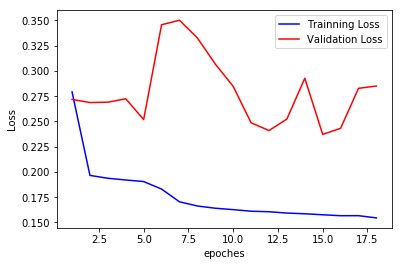

0.23719755,15,tensor(0.2461, device='cuda:0')


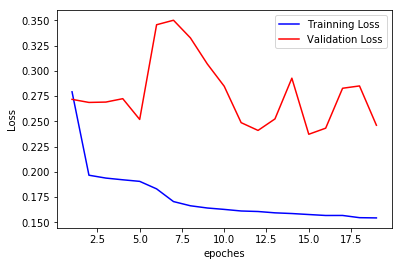

0.23719755,15,tensor(0.2536, device='cuda:0')


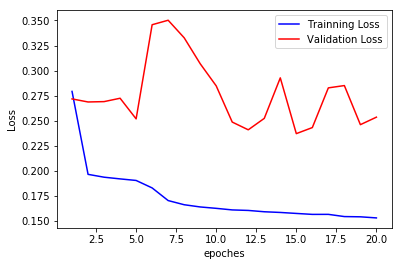

0.23719755,15,tensor(0.2803, device='cuda:0')


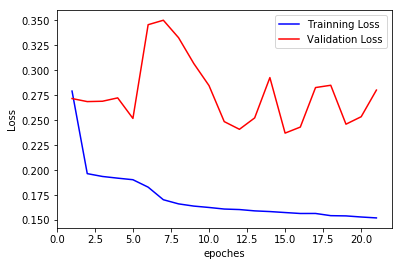

0.22811316,22,tensor(0.2281, device='cuda:0')


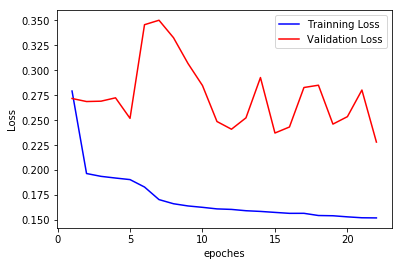

0.22811316,22,tensor(0.2557, device='cuda:0')


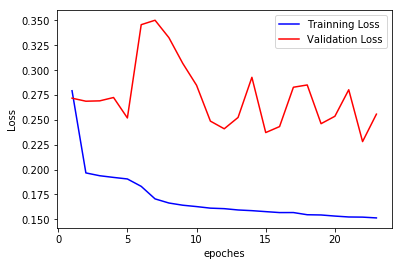

0.22811316,22,tensor(0.2287, device='cuda:0')


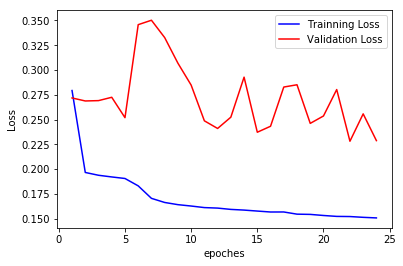

0.22429384,25,tensor(0.2243, device='cuda:0')


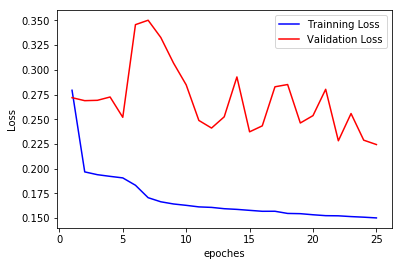

0.22429384,25,tensor(0.2347, device='cuda:0')


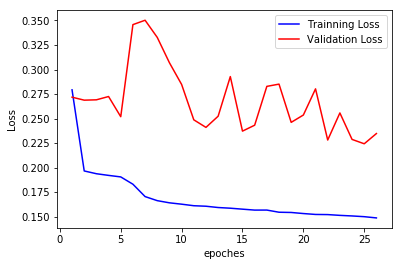

0.22429384,25,tensor(0.2444, device='cuda:0')


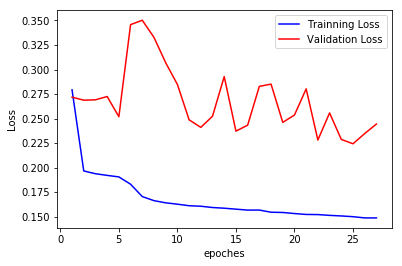

0.22429384,25,tensor(0.2962, device='cuda:0')


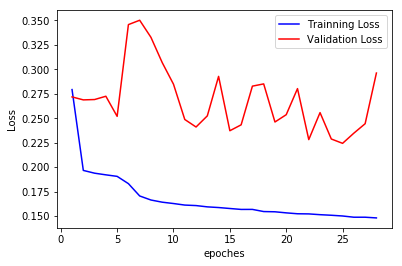

0.22429384,25,tensor(0.2367, device='cuda:0')


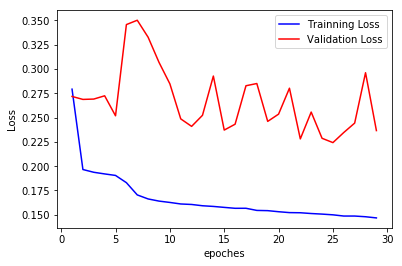

0.22429384,25,tensor(0.2827, device='cuda:0')


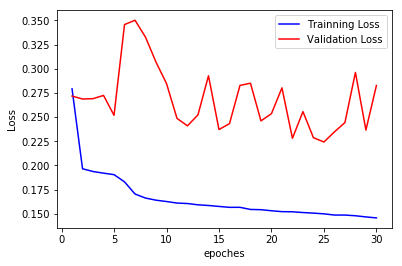

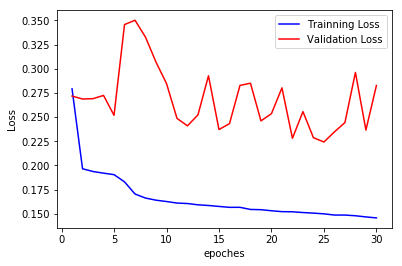

32,2,0.22429384,25,0.14574611,30
22:08:28 1236.511970281601
22:08:28
0.2816185,1,tensor(0.2816, device='cuda:0')
0.2816185,1,tensor(0.2860, device='cuda:0')
0.27918956,3,tensor(0.2792, device='cuda:0')
0.27813807,4,tensor(0.2781, device='cuda:0')
0.27509665,5,tensor(0.2751, device='cuda:0')
0.2732594,6,tensor(0.2733, device='cuda:0')
0.27021348,7,tensor(0.2702, device='cuda:0')
0.23440152,8,tensor(0.2344, device='cuda:0')


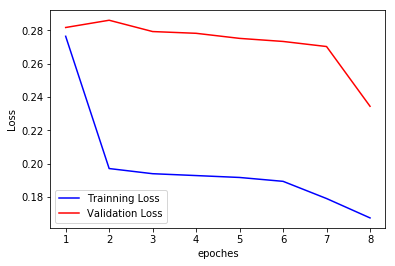

0.22347464,9,tensor(0.2235, device='cuda:0')


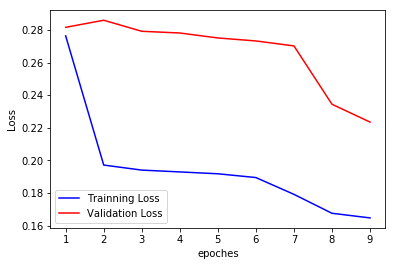

0.22191837,10,tensor(0.2219, device='cuda:0')


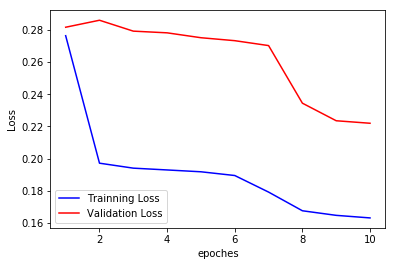

0.22181186,11,tensor(0.2218, device='cuda:0')


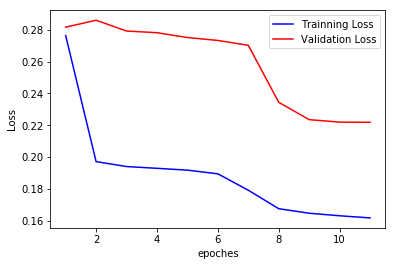

0.22181186,11,tensor(0.2381, device='cuda:0')
0.22109483,13,tensor(0.2211, device='cuda:0')


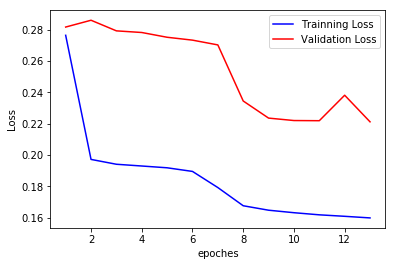

0.22109483,13,tensor(0.2237, device='cuda:0')
0.22109483,13,tensor(0.2301, device='cuda:0')


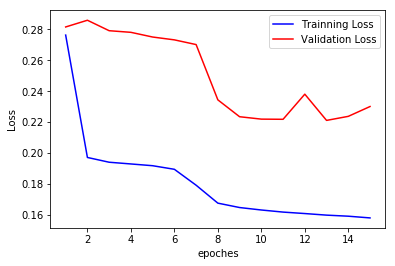

0.22109483,13,tensor(0.2291, device='cuda:0')


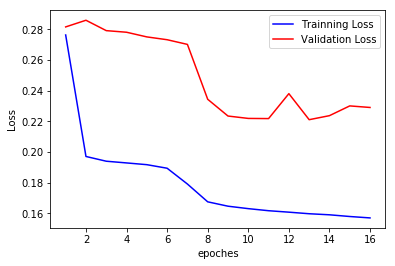

0.22109483,13,tensor(0.2414, device='cuda:0')


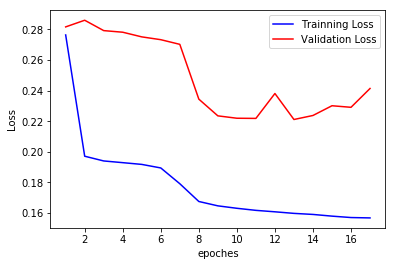

0.22109483,13,tensor(0.2391, device='cuda:0')


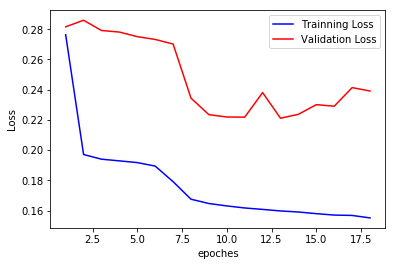

0.22109483,13,tensor(0.2438, device='cuda:0')


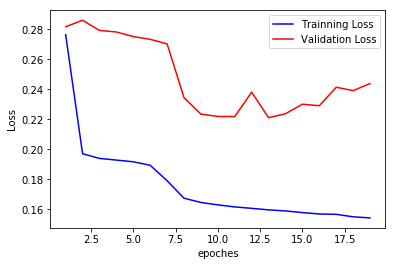

0.22109483,13,tensor(0.2431, device='cuda:0')


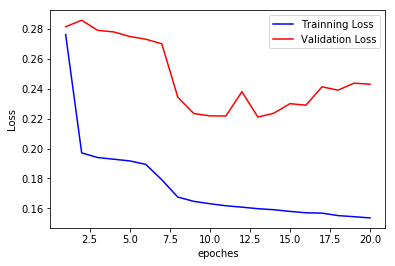

0.22109483,13,tensor(0.2451, device='cuda:0')


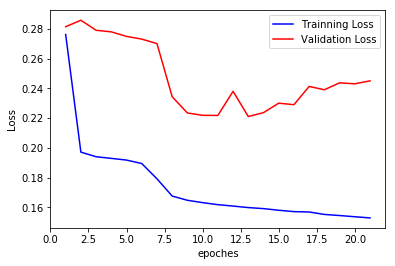

0.22109483,13,tensor(0.2500, device='cuda:0')


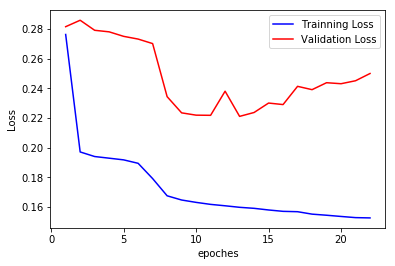

0.22109483,13,tensor(0.2639, device='cuda:0')


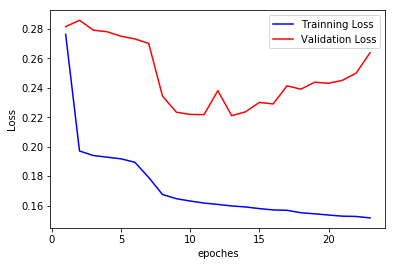

0.22109483,13,tensor(0.2439, device='cuda:0')


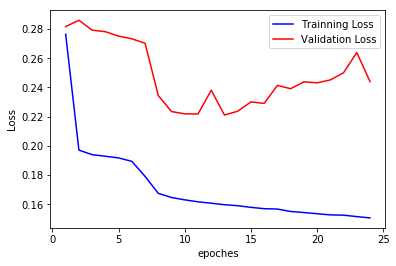

0.22109483,13,tensor(0.2545, device='cuda:0')


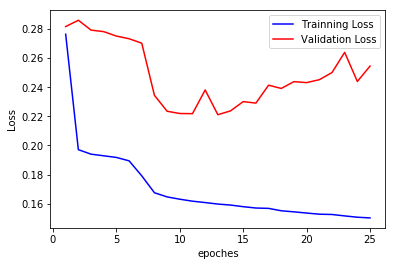

0.22109483,13,tensor(0.2482, device='cuda:0')


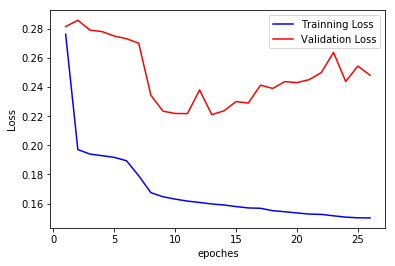

0.22109483,13,tensor(0.2548, device='cuda:0')


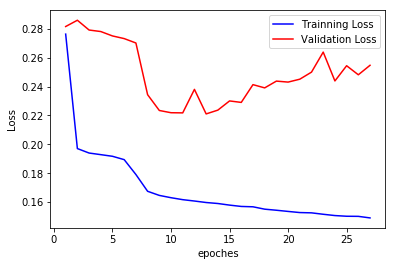

0.22109483,13,tensor(0.2538, device='cuda:0')


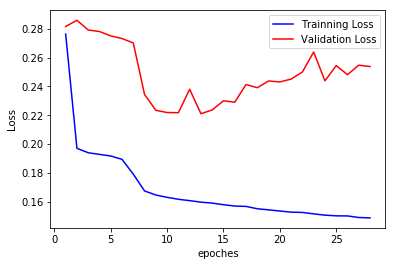

0.22109483,13,tensor(0.2666, device='cuda:0')


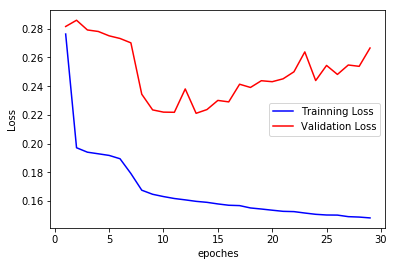

0.22109483,13,tensor(0.2666, device='cuda:0')


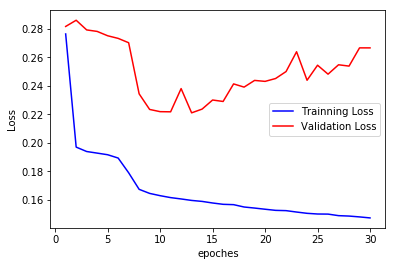

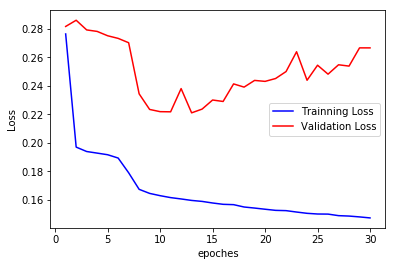

32,2,0.22109483,13,0.14748111,30
22:29:10 1241.8216290473938
22:29:10
0.27079934,1,tensor(0.2708, device='cuda:0')
0.26762557,2,tensor(0.2676, device='cuda:0')
0.26564026,3,tensor(0.2656, device='cuda:0')
0.26507348,4,tensor(0.2651, device='cuda:0')
0.26507348,4,tensor(0.2709, device='cuda:0')
0.26507348,4,tensor(0.2849, device='cuda:0')
0.26507348,4,tensor(0.2993, device='cuda:0')
0.2555939,8,tensor(0.2556, device='cuda:0')


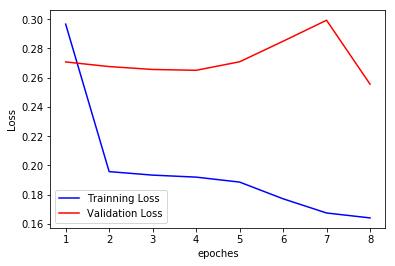

0.22882046,9,tensor(0.2288, device='cuda:0')


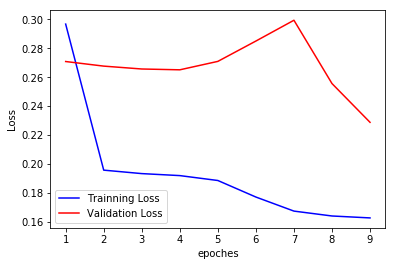

0.22882046,9,tensor(0.2485, device='cuda:0')
0.22882046,9,tensor(0.2325, device='cuda:0')
0.22882046,9,tensor(0.2366, device='cuda:0')
0.22882046,9,tensor(0.2535, device='cuda:0')
0.22882046,9,tensor(0.2479, device='cuda:0')
0.22164479,15,tensor(0.2216, device='cuda:0')


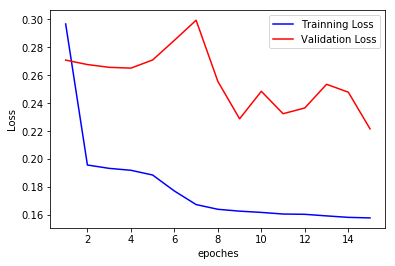

0.22164479,15,tensor(0.2399, device='cuda:0')


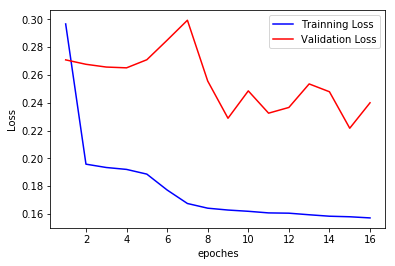

0.22164479,15,tensor(0.2308, device='cuda:0')


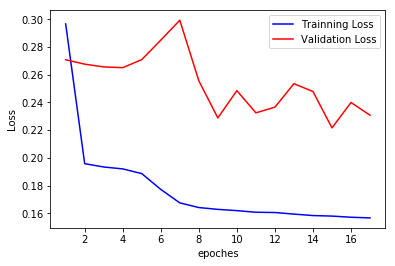

0.22164479,15,tensor(0.2299, device='cuda:0')


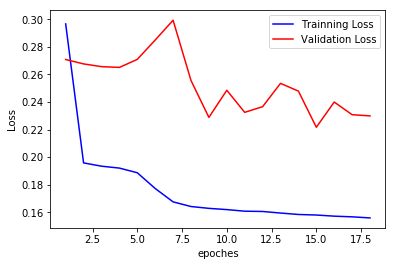

0.22164479,15,tensor(0.2464, device='cuda:0')


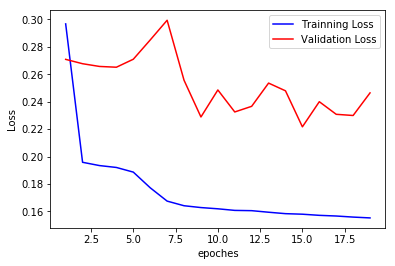

0.22164479,15,tensor(0.2252, device='cuda:0')


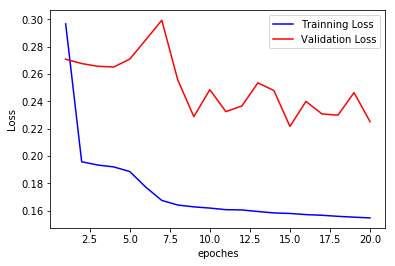

0.22164479,15,tensor(0.2350, device='cuda:0')


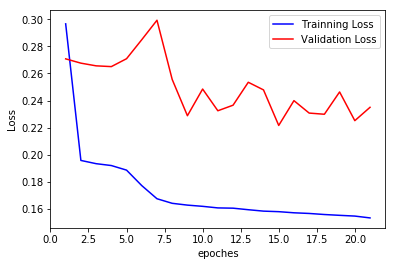

0.22164479,15,tensor(0.2390, device='cuda:0')


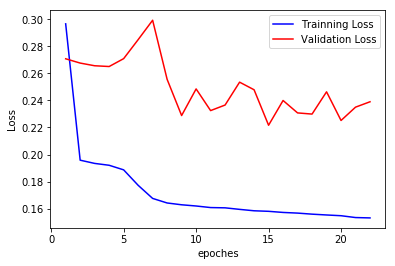

0.22164479,15,tensor(0.2445, device='cuda:0')


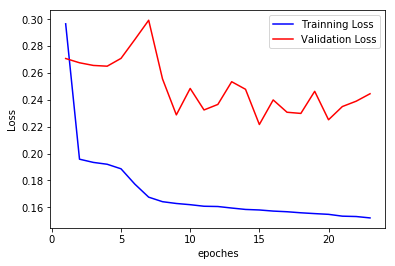

0.22164479,15,tensor(0.2366, device='cuda:0')


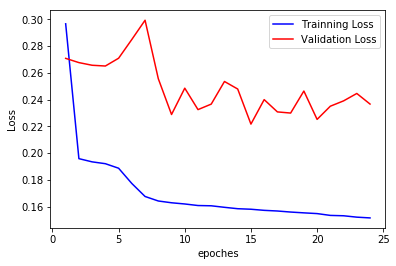

0.22164479,15,tensor(0.2422, device='cuda:0')


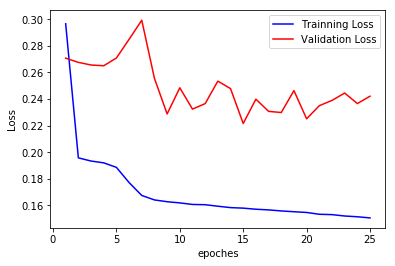

0.22164479,15,tensor(0.2683, device='cuda:0')


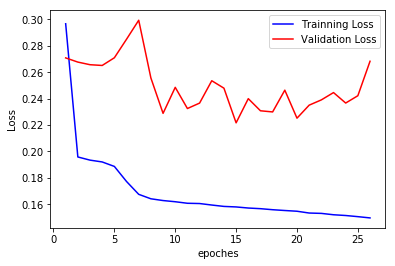

0.22164479,15,tensor(0.2657, device='cuda:0')


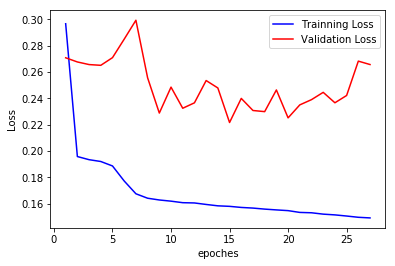

0.22164479,15,tensor(0.2778, device='cuda:0')


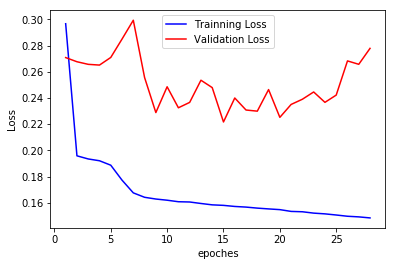

0.22164479,15,tensor(0.2692, device='cuda:0')


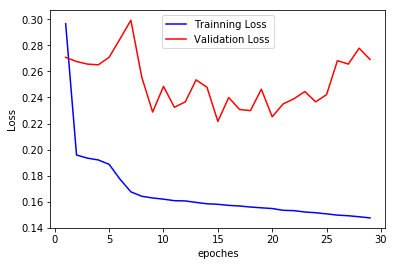

0.22164479,15,tensor(0.2666, device='cuda:0')


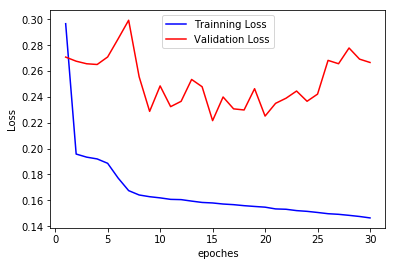

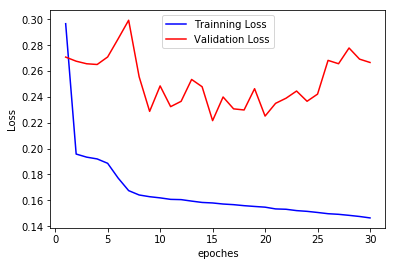

32,2,0.22164479,15,0.14641106,30
22:49:45 1235.0826165676117
22:49:45
0.29227725,1,tensor(0.2923, device='cuda:0')
0.2857579,2,tensor(0.2858, device='cuda:0')
0.27328974,3,tensor(0.2733, device='cuda:0')
0.27136025,4,tensor(0.2714, device='cuda:0')
0.26847282,5,tensor(0.2685, device='cuda:0')
0.22392431,6,tensor(0.2239, device='cuda:0')
0.22392431,6,tensor(0.2250, device='cuda:0')
0.22392431,6,tensor(0.2320, device='cuda:0')
0.22392431,6,tensor(0.2347, device='cuda:0')
0.22392431,6,tensor(0.2495, device='cuda:0')
0.22392431,6,tensor(0.2390, device='cuda:0')
0.22392431,6,tensor(0.2457, device='cuda:0')
0.22392431,6,tensor(0.2410, device='cuda:0')
0.22392431,6,tensor(0.2383, device='cuda:0')
0.22392431,6,tensor(0.2577, device='cuda:0')


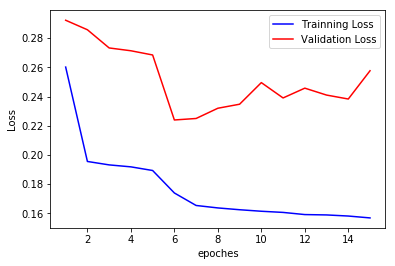

0.22392431,6,tensor(0.2483, device='cuda:0')


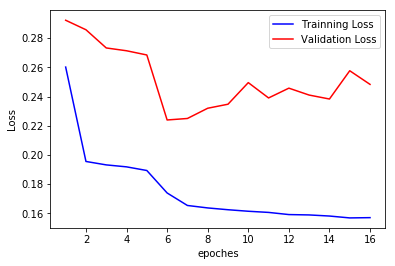

0.22392431,6,tensor(0.2433, device='cuda:0')


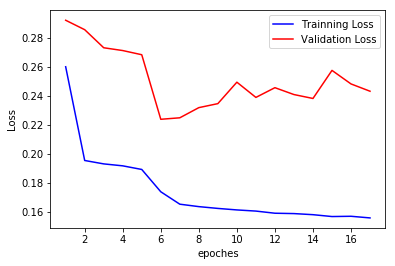

0.22392431,6,tensor(0.2552, device='cuda:0')


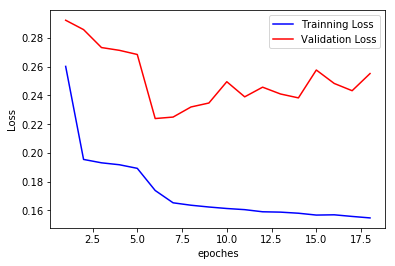

0.22392431,6,tensor(0.2573, device='cuda:0')


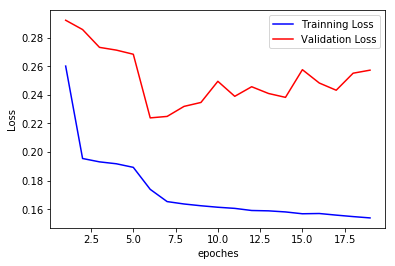

0.22392431,6,tensor(0.2425, device='cuda:0')


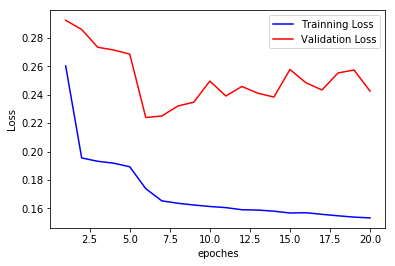

0.22392431,6,tensor(0.2473, device='cuda:0')


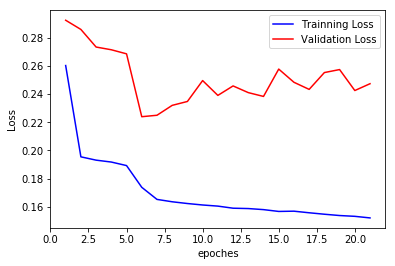

0.22392431,6,tensor(0.2511, device='cuda:0')


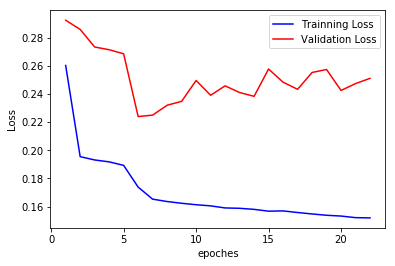

0.22392431,6,tensor(0.2443, device='cuda:0')


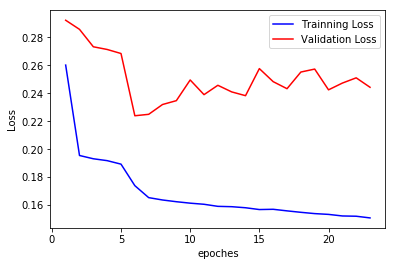

0.22392431,6,tensor(0.2640, device='cuda:0')


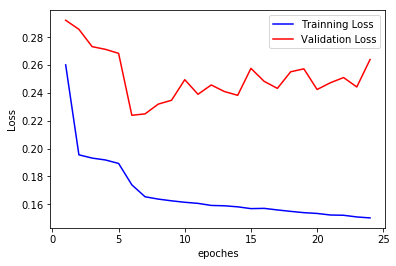

0.22392431,6,tensor(0.2495, device='cuda:0')


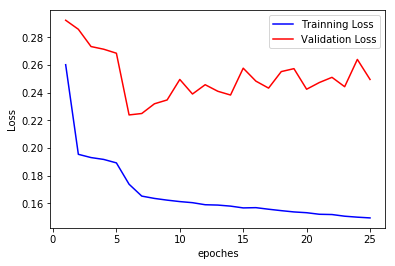

0.22392431,6,tensor(0.2451, device='cuda:0')


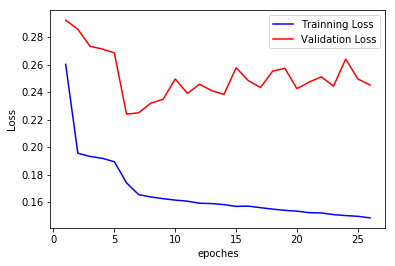

0.22392431,6,tensor(0.2530, device='cuda:0')


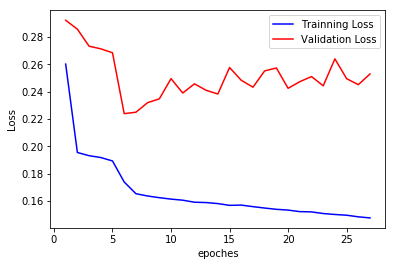

0.22392431,6,tensor(0.2509, device='cuda:0')


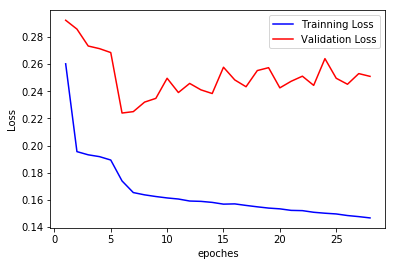

0.22392431,6,tensor(0.2444, device='cuda:0')


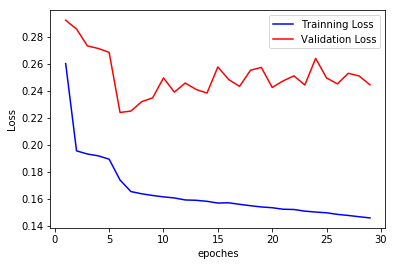

0.22392431,6,tensor(0.2460, device='cuda:0')


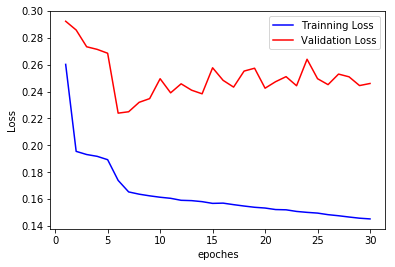

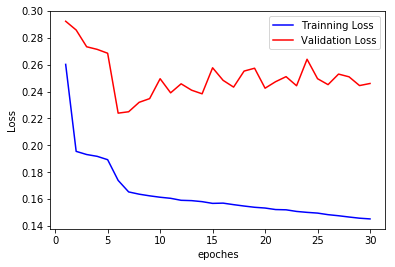

32,2,0.22392431,6,0.14524825,30
23:10:21 1236.290055513382
23:10:21
0.2765177,1,tensor(0.2765, device='cuda:0')
0.27332562,2,tensor(0.2733, device='cuda:0')
0.27162722,3,tensor(0.2716, device='cuda:0')
0.26798478,4,tensor(0.2680, device='cuda:0')
0.2513174,5,tensor(0.2513, device='cuda:0')
0.2513174,5,tensor(0.2818, device='cuda:0')
0.2513174,5,tensor(0.2827, device='cuda:0')
0.22092788,8,tensor(0.2209, device='cuda:0')


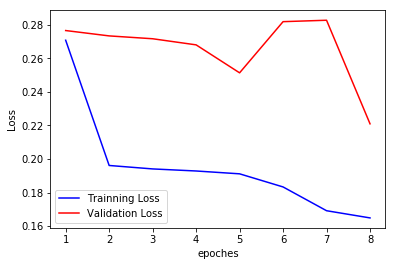

0.22092788,8,tensor(0.2269, device='cuda:0')
0.22092788,8,tensor(0.2233, device='cuda:0')
0.22092788,8,tensor(0.2235, device='cuda:0')
0.22092788,8,tensor(0.2216, device='cuda:0')
0.22092788,8,tensor(0.2302, device='cuda:0')
0.22092788,8,tensor(0.2260, device='cuda:0')
0.22092788,8,tensor(0.2280, device='cuda:0')


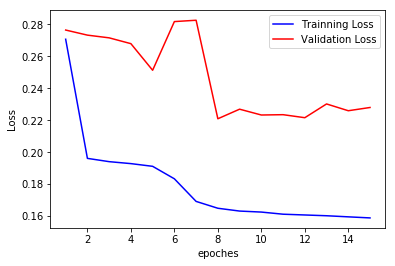

0.22092788,8,tensor(0.2366, device='cuda:0')


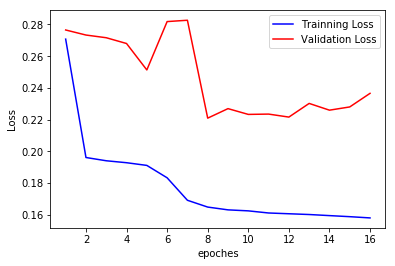

0.22092788,8,tensor(0.2374, device='cuda:0')


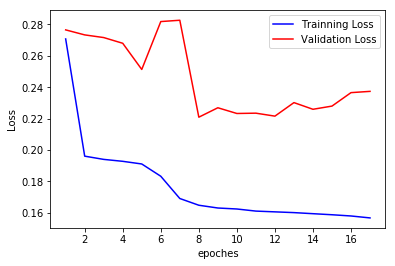

0.22092788,8,tensor(0.2366, device='cuda:0')


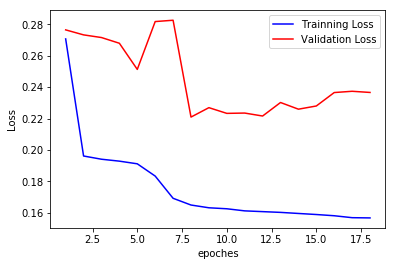

0.22092788,8,tensor(0.2505, device='cuda:0')


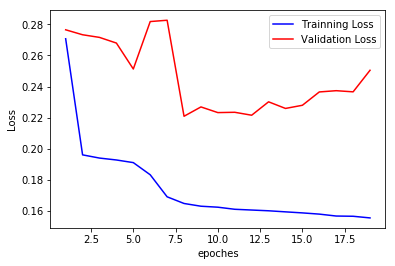

0.22092788,8,tensor(0.2520, device='cuda:0')


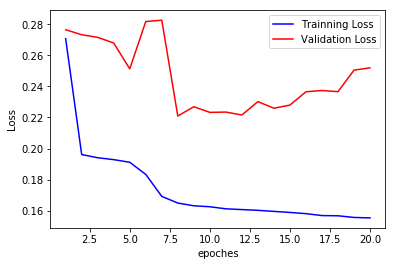

0.22092788,8,tensor(0.2578, device='cuda:0')


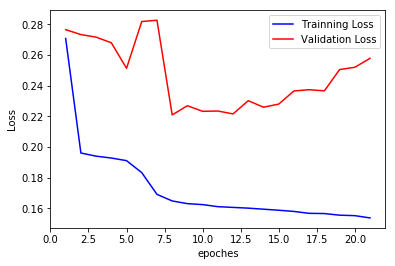

0.22092788,8,tensor(0.2477, device='cuda:0')


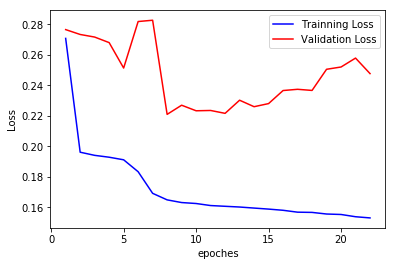

0.22092788,8,tensor(0.2617, device='cuda:0')


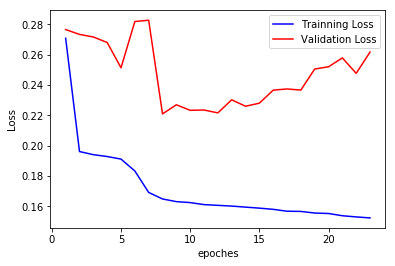

0.22092788,8,tensor(0.2523, device='cuda:0')


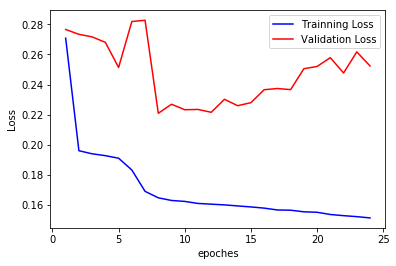

0.22092788,8,tensor(0.2409, device='cuda:0')


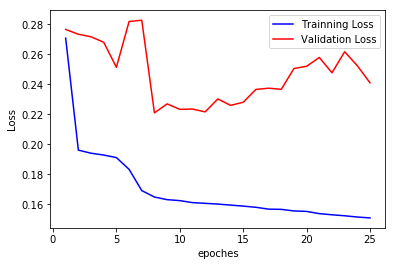

0.22092788,8,tensor(0.2661, device='cuda:0')


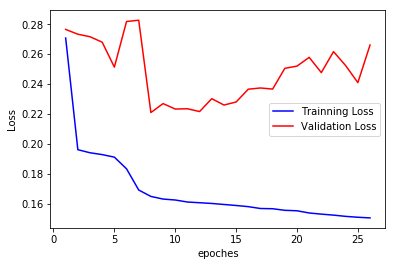

0.22092788,8,tensor(0.2533, device='cuda:0')


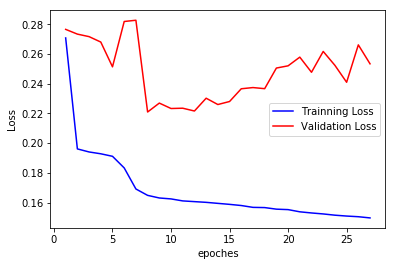

0.22092788,8,tensor(0.2540, device='cuda:0')


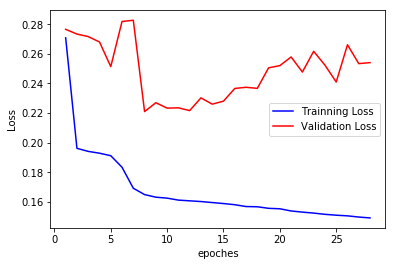

0.22092788,8,tensor(0.2669, device='cuda:0')


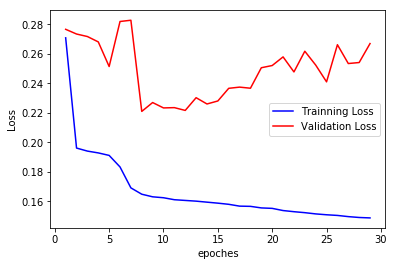

0.22092788,8,tensor(0.3083, device='cuda:0')


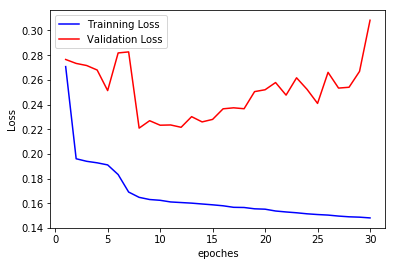

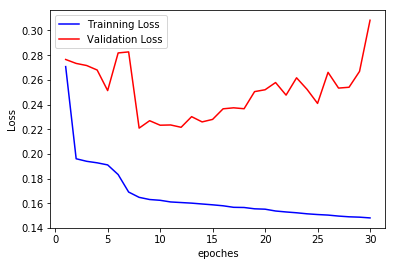

32,2,0.22092788,8,0.14819337,30
23:30:47 1226.1654615402222
23:30:47
0.27527827,1,tensor(0.2753, device='cuda:0')
0.26396853,2,tensor(0.2640, device='cuda:0')
0.26396853,2,tensor(0.2647, device='cuda:0')
0.26310128,4,tensor(0.2631, device='cuda:0')
0.2564687,5,tensor(0.2565, device='cuda:0')
0.2564687,5,tensor(0.3042, device='cuda:0')
0.2264479,7,tensor(0.2264, device='cuda:0')
0.2264479,7,tensor(0.2291, device='cuda:0')
0.2264479,7,tensor(0.2320, device='cuda:0')
0.2264479,7,tensor(0.2559, device='cuda:0')
0.2264479,7,tensor(0.2301, device='cuda:0')
0.21314363,12,tensor(0.2131, device='cuda:0')


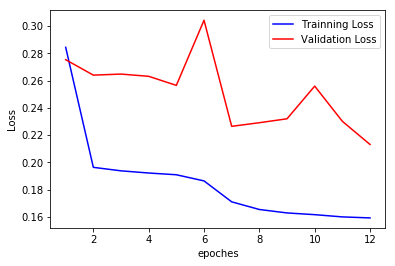

0.21314363,12,tensor(0.2190, device='cuda:0')
0.21314363,12,tensor(0.2146, device='cuda:0')
0.21314363,12,tensor(0.2271, device='cuda:0')


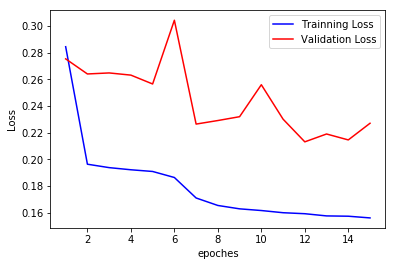

0.21314363,12,tensor(0.2229, device='cuda:0')


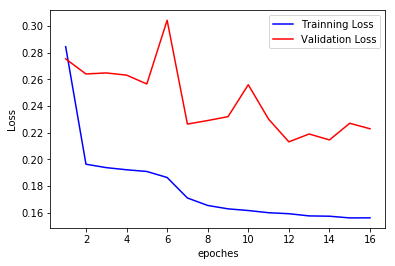

0.21314363,12,tensor(0.2177, device='cuda:0')


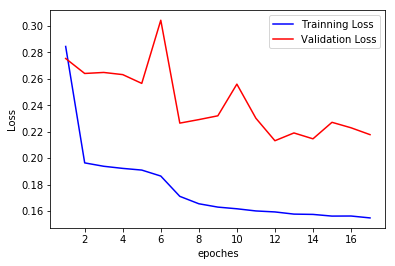

0.21314363,12,tensor(0.2210, device='cuda:0')


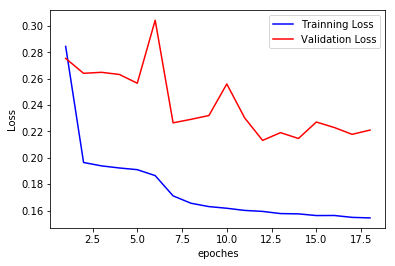

0.21314363,12,tensor(0.2235, device='cuda:0')


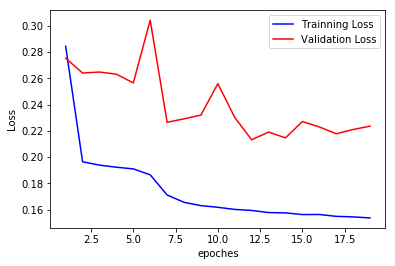

0.21314363,12,tensor(0.2217, device='cuda:0')


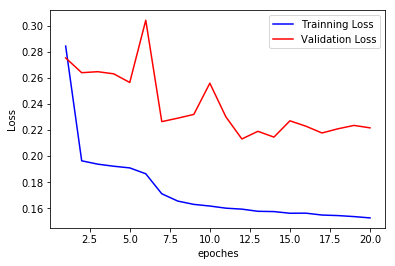

0.21314363,12,tensor(0.2159, device='cuda:0')


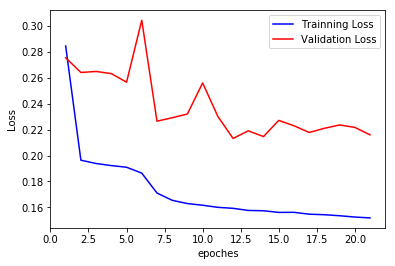

0.21314363,12,tensor(0.2179, device='cuda:0')


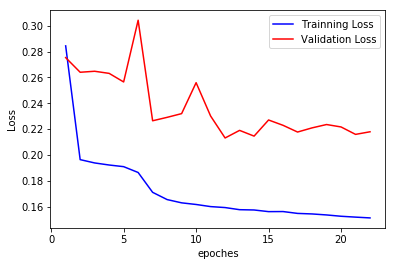

0.21314363,12,tensor(0.2232, device='cuda:0')


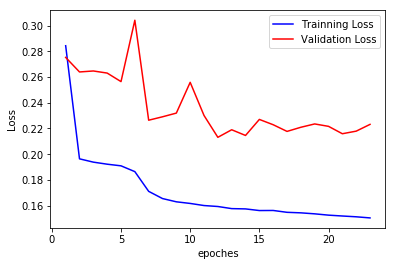

0.21314363,12,tensor(0.2274, device='cuda:0')


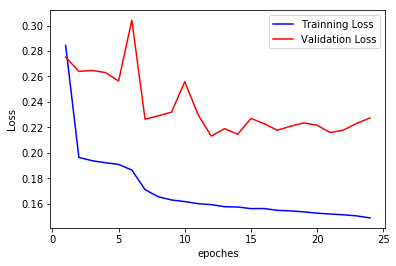

0.21314363,12,tensor(0.2300, device='cuda:0')


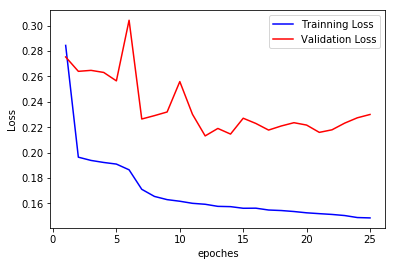

0.21314363,12,tensor(0.2323, device='cuda:0')


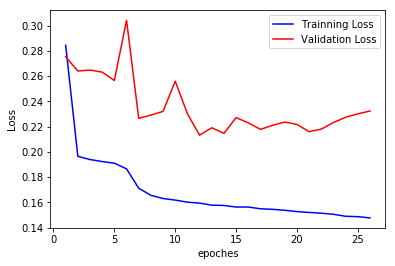

0.21314363,12,tensor(0.2319, device='cuda:0')


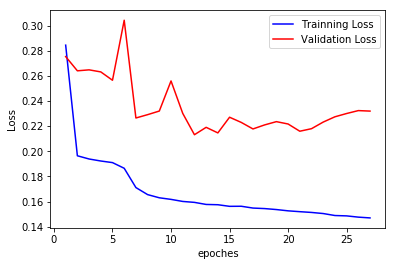

0.21314363,12,tensor(0.2383, device='cuda:0')


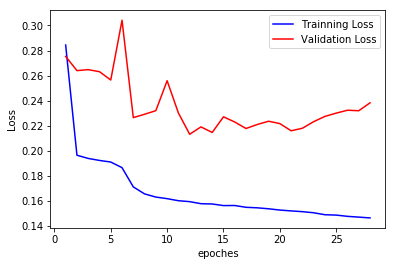

0.21314363,12,tensor(0.2348, device='cuda:0')


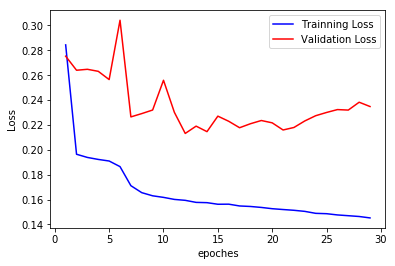

0.21314363,12,tensor(0.2519, device='cuda:0')


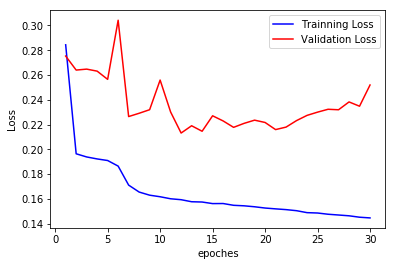

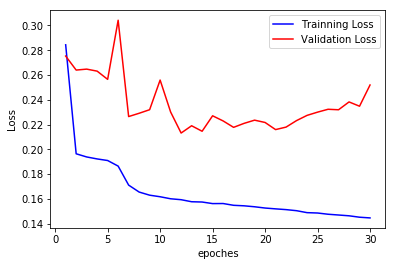

32,2,0.21314363,12,0.14462864,30
23:51:21 1233.4074351787567
23:51:21
0.28274006,1,tensor(0.2827, device='cuda:0')
0.2714393,2,tensor(0.2714, device='cuda:0')
0.2714393,2,tensor(0.2749, device='cuda:0')


KeyboardInterrupt: 

In [35]:
while True:
    #print(32, 2, sep = ', ')
    print(time.strftime("%H:%M:%S"))
    T = time.time()
    train(32, 2, 30, 'log.csv', train_loader, test_loader)
    print(time.strftime("%H:%M:%S"), time.time()-T, sep=' ')
    #print(32, 3, sep = ', ')
    #train(32, 3, 54, 'log.csv', train_loader, test_loader)
    train_loader, test_loader = 0, 0
    torch.cuda.empty_cache()
    train_loader = torch.utils.data.DataLoader(
        dataset=trainset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        dataset=testset, batch_size=batch_size, shuffle=True)

In [ ]:
hs = 12
hl = 8
ep = 4
weight_path = './weight_' + str(hs) + '_' + str(hl) + '_'+ str(ep) + '.p'
RNN = FundLSTM(input_size=input_size, output_size=output_size,
               hidden_size=hs, hidden_layers=hl).cuda()
RNN.load_state_dict(torch.load(weight_path, map_location=lambda storage, loc: storage.cuda(0)))
with open('result.csv', 'w+') as f:
    f.write('ID,value\n')
    f.close()
f = open('result.csv', 'a+')
for i in range(1, 200):
    for j in range(i+1, 201):
        # d = gen_once(i, j)
        # RNN = train(hs=hidden_size[1], hl=hidden_layers[-1], epmax=4, datas=d)
        output_list = RNN(torch.autograd.Variable(torch.Tensor([gen4submit(i, j)]).cuda()))
        output_list = output_list.data.squeeze().cpu().numpy()
        f.write('Fund '+str(i)+'-'+'Fund '+str(j) + ',' + str(output_list[-1])+'\n')
        torch.cuda.empty_cache()
    print(i, 'done', sep=' ')